# View on [nbviewer.jupyter.org](https://nbviewer.jupyter.org/github/icweaver/pyhat/blob/master/toymodel_gaussian.ipynb?flush_cache=true)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import scipy as sp
import pymc3 as pm
import pandas as pd
import utils
import plotutils

In [4]:
# plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

# Standard normal example

$\newcommand{\rhat}{\widehat R}$
The following toy problem will help us demonstrate an improved diagnostic for MCMC convergence proposed by [Vehtari et al. (2019)](https://arxiv.org/pdf/1903.08008.pdf). This method uses the classic split-$\rhat$ metric, but in a novel way.

## Sample data

We'll start by creating some test data drawn from the standard normal distribution. This is what we will run our MCMC sampler on as a base case to highlight the problems with the current way split-$\rhat$ is used and methods to improve it suggested by the authors.

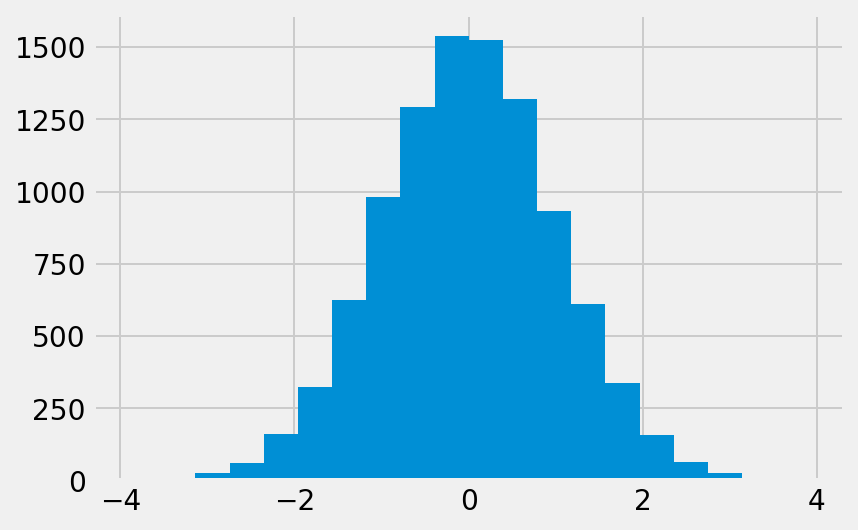

In [99]:
seed = 42
np.random.seed(seed)
data = np.random.normal(size=10_000)
plt.hist(data, bins=20)
plt.show()

## Run MCMC sampler

Let's now fit the data $y$ with the following model to be explored by our sampler:

$$
    \mu \sim \mathcal N(0, 1) \\
    y|\theta \sim \mathcal N(\mu, 1)
$$

In [331]:
params = ["mu"] # parameters to fit for
with pm.Model() as model:
    mu = pm.Normal(params[0], 0, 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=1.0, observed=data)

with model:
    trace = pm.sample(1_000, chains=4, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:09<00:00, 804.00draws/s] 


This model fits a normal curve with variance 1 and a single parameter $\theta$ that represents the mean $\mu$ and is given a standard normal prior. Below is a typical trace plot of the chains (right) and corresponding histogram (left) after the sampler has finished.

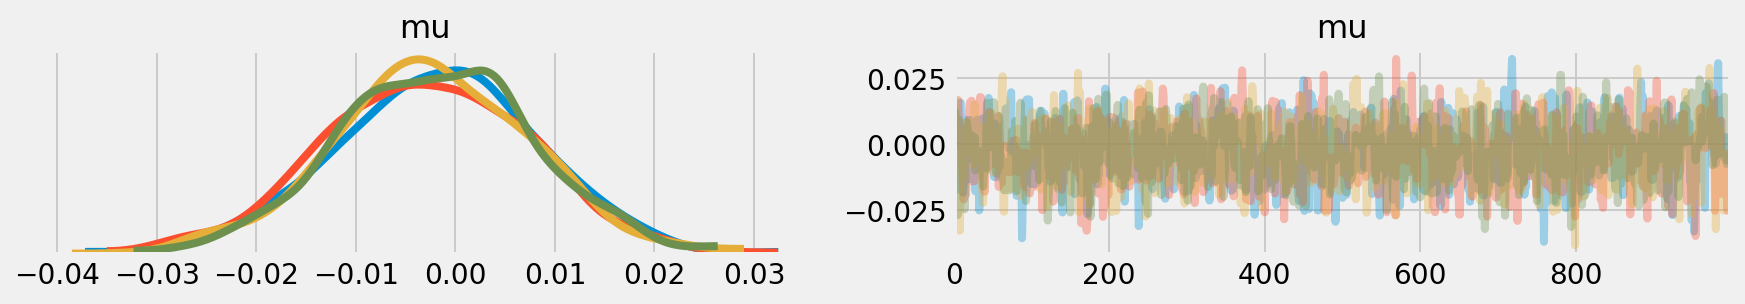

In [332]:
pm.traceplot(trace)
plt.show()

By eye the chains look to be converging. This statement is typically quantified by using the diagnostic metric:

$$
\rhat = \sqrt{\frac{\widehat{\text{var}}^+(\theta|y)}{W}},\quad
\widehat{\text{var}}^+(\theta|y) = \frac{N - 1}{N}W + \frac{1}{N}B,\quad
$$

where $\widehat{\text{var}}^+(\theta|y)$ is the marginal posterior variance of the parameters $\theta$ given the data $y$, $N$ is the number of samples in our MCMC chain, and $B$ and $W$ are the standard between- and within-chain variances defined in Equations 1 and 2 of the paper, respectively. A similar, but more robust diagnostic metric, split-$\rhat$ is calculated in the same way, except that the chains are first split in half, doubling $M$ and halving $N$. This has the added benefit of being sensitive to non-stationary chains. 

We can check if our implementation of $\rhat$ agrees with the one baked into the popular python package `pymc3`, which we also used as our sampler.

In [333]:
rhat = utils.rhat(trace, param=params[0], split=False)
rhat_pymc = pm.diagnostics.gelman_rubin(trace)[params[0]]

# compare our implemention to pymc3's
print(f"rhat_pymc:  {rhat_pymc}")
print(f"rhat:       {rhat}")

rhat_pymc:  1.0006222131931348
rhat:       1.0006222131931348


It looks like `pymc3` is using the standard definition for $\rhat$, which has since been outdated by the split-$\rhat$ method commonly used by packages like `stan`. Let's check that next.

In [334]:
rhat_split = utils.rhat(trace, param=params[0], split=True)

# compare split to previous un-split
print(f"rhat_split: {rhat_split}")
print(f"rhat:       {rhat}\n")
utils.print_percent_diff(rhat_split, rhat)

rhat_split: 1.0004776945816982
rhat:       1.0006222131931348

percent difference: 0.01%


We can see here that the split-$\rhat$ method can actually differ from the standard definition, even for a basic case like this. Let's test its robustness next by testing what happens if one of our chains happens to have a larger variance than the others.

# Increased variance example

We want to see that if we replace one of the chains of the original model with a fake model whether the traditional $\widehat{R}$ metric is able to understand this and whether the new metric can also understand this. Our fake model with have a variance of 4 now instead of 1:

In [335]:
with pm.Model() as model_fake:
    mu = pm.Normal(params[0], 0, 1.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=2.0, observed=data)

with model_fake:
    trace_fake = pm.sample(1_000, chains=2, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 534.21draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C05B88A58>,
      dtype=object)

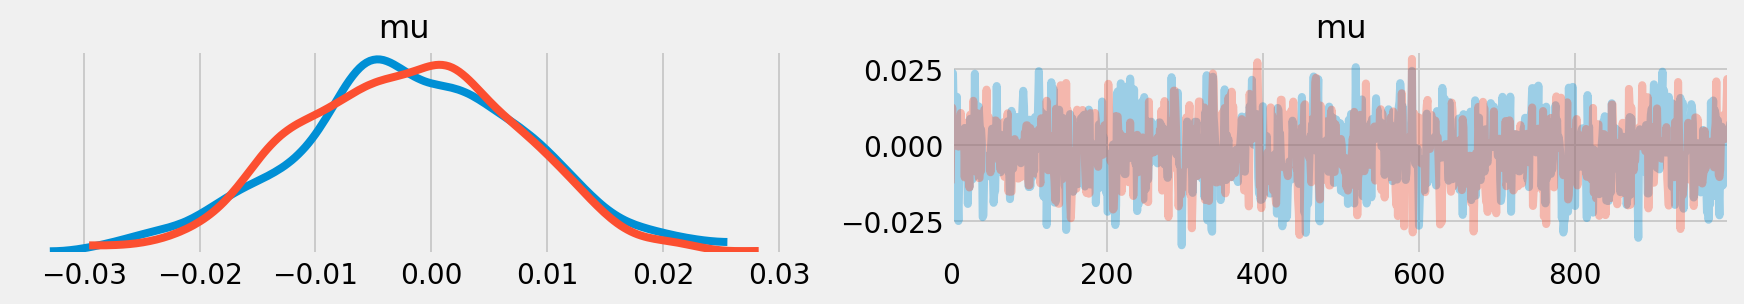

In [336]:
pm.traceplot(trace_fake)

In [337]:
# extract trace array from pymc3's MultiTrace object
trace_dvar = np.array(trace.get_values(params[0], combine=False)) 
# replace first chain of trace array with the fake chain
trace_dvar[0, :] = np.array(trace_fake.get_values(params[0], combine=False))[0, :]


# compare to non-split example
rhat_split_dvar = utils.rhat(trace_dvar, split=True)
rhat_dvar = utils.rhat(trace_dvar, split=False)
print(f"rhat_dvar:       {rhat_dvar}")
print(f"rhat_split_dvar: {rhat_split_dvar}\n")
utils.print_percent_diff(rhat_split_dvar, rhat_dvar)

rhat_dvar:       1.0008894375704982
rhat_split_dvar: 1.0008142695427618

percent difference: 0.01%


This fake injection does not affect the $\rhat$ metric, both split and traditional. Moreover, if we relied solely on the traceplot, we would also think that our chains have converged successfully.

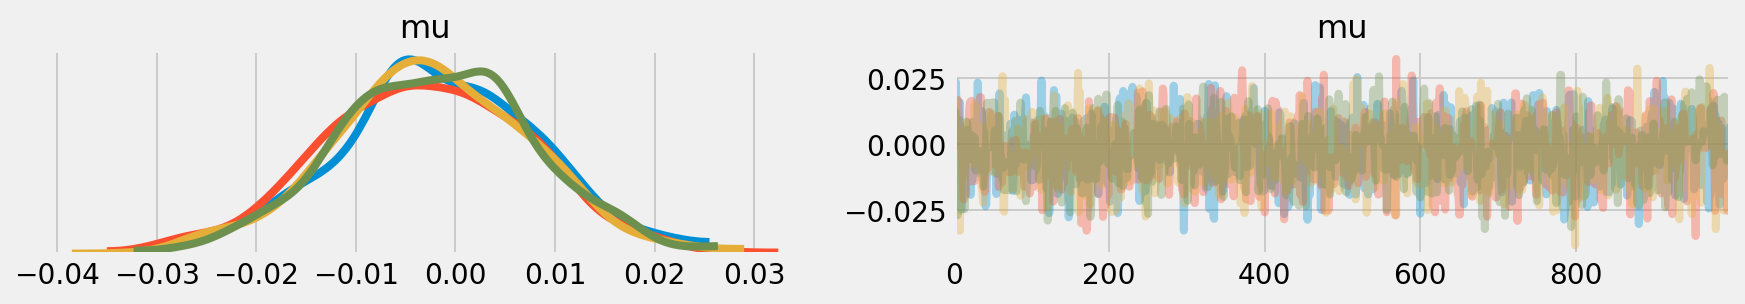

In [338]:
trace_dvar_dict = {params[0]:trace_dvar}
pm.traceplot(trace_dvar_dict)
plt.show()

This next example will show a method to further improve the reliability of split-$\rhat$ which can be sensitive to convergence issues like the one shown above.

# Rank normalized $\rhat$

This new method uses the same implementation of split-$\rhat$, but first transforms each chain before computing it. The transformation is given by Equation 6 in the text:

$$
z^{(nm)} = \Phi^{-1}\left[\frac{r^{(nm)} - 0.5}{S}\right] \quad,
$$

where $r^{(nm)}$ is the rank of $\theta^{(nm)}$, the $n$th parameter estimate of $N$ samples in the $m$th chain of $M$ total chains, and $S$ is the effective sample size estimate, and $\Phi^{-1}$ is the inverse normal transform.

First, we define function `zscale` that will project the traces into a standard Gaussian:

```python
def zscale(trace):
    S = len(trace.flatten())
    r = utils.rank(trace.flatten())
    z = sp.stats.norm.ppf((r - 0.5) / S).reshape(trace.shape)
    return z
```

We test `zscale` to make sure it is projecting everything to a Gaussian with $\mu = 0$ and $\sigma = 1$. 

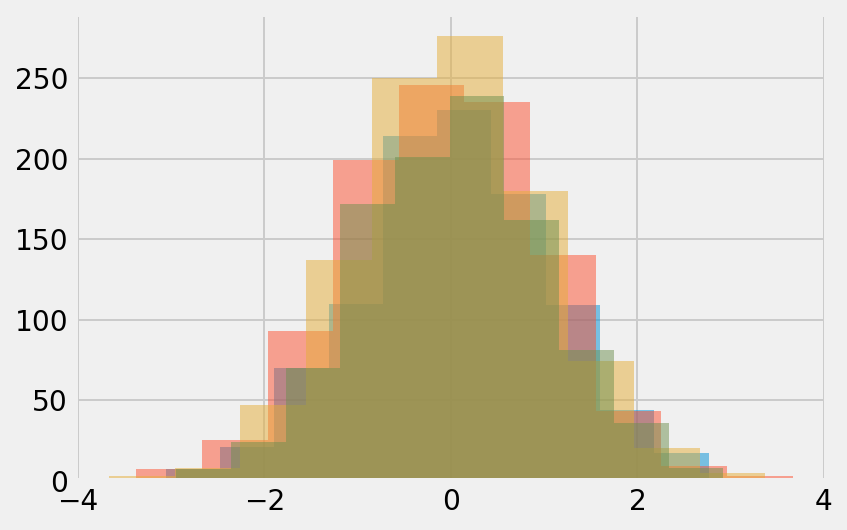

In [339]:
plotutils.zscale_hist(trace_dvar)

Now, we calculate the $\rhat$ metric called the *rank-normalized-split-*$\rhat$:

In [340]:
z_dvar = utils.zscale(trace_dvar)
rhat_split_dvar_rank = utils.rhat(z_dvar, split=True)

# compare to previous un-ranked example
print(f"rhat_split_dvar:       {rhat_split_dvar}")
print(f"rhat_split_dvar_rank:  {rhat_split_dvar_rank}\n")
utils.print_percent_diff(rhat_split_dvar_rank, rhat_split_dvar)

rhat_split_dvar:       1.0008142695427618
rhat_split_dvar_rank:  1.0008034593309285

percent difference: 0.00%


This can still be fooled if the chains have the same location but different scales. The authors recommend computing the *rank-normalized-split-*$\rhat$ for the folded draws $\zeta^{nm}$. This is given by Equation 7 in the text:

$$
\zeta^{(nm)} = \left| \theta^{(nm)} - \text{median}(\theta) \right| \quad,
$$

and is termed the *folded-split* $\rhat$. This alternative ranked-normalized $\rhat$ is important because of its sensitivity to convergence in the tails of our chains. For this reason, the authors note that we should report the maximum between the *rank-normalized-split-*$\rhat$ and the *folded-split-*$\rhat$. when performing convergence diagnostics.

We implement the folded variant with `folded_split_rhat` and see the following results:

```python
def folded_split_rhat(trace, param):
    zeta = np.abs(trace - np.median(trace).reshape(-1, 1))
    zscale_folded = zscale(zeta)
    return utils.rhat(zscale_folded, param, split = True)
```

In [341]:
rhat_split_dvar_rank_folded = utils.folded_split_rhat(trace_dvar)

# compare to previous un-folded example
print(f"rhat_split_dvar_rank:        {rhat_split_dvar_rank}")
print(f"rhat_split_dvar_rank_folded: {rhat_split_dvar_rank_folded}\n")
utils.print_percent_diff(rhat_split_dvar_rank_folded, rhat_split_dvar_rank)

rhat_split_dvar_rank:        1.0008034593309285
rhat_split_dvar_rank_folded: 1.0004770518956407

percent difference: 0.03%


The *folded-split-*$\rhat$ does a much better job of detecting the non-converging chain, shown by the $\rhat$ value well above the conventional 1.01 convergence limit reported in the literature.

# $\rhat$ summary

Below, we copy the results from each method for easy comparison.

In [326]:
# regular vs. split rhat
print(f"rhat:                        {rhat}")
print(f"rhat_split:                  {rhat_split}\n")

# regular vs. split rhat on dvar chains
print(f"rhat_dvar:                   {rhat_dvar}")
print(f"rhat_split_dvar:             {rhat_split_dvar}\n")

# split-rank vs. split-rank-folded on dvar chains
print(f"rhat_split_dvar_rank:        {rhat_split_dvar_rank}")
print(f"rhat_split_dvar_rank_folded: {rhat_split_dvar_rank_folded}\n")

rhat:                        <function rhat at 0x0000020C5EF8C488>


NameError: name 'rhat_split' is not defined

# Rank plots

Now we show the rank plot to diagnose chains with `rankplot` .

```python
def rankplot(trace, nchains, rows, cols):
    """Returns rank plot for a given chain.
    Parameters
    ----------
    trace : numpy array of trace.
    nchains : number of chains to be plotted; nchains = rows * cols
    rows : number of rows in the plot
    cols: number of cols in the plot
    """
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(17, 10))
    gs = GridSpec(rows, cols)
    
    r = rank(trace.flatten()).reshape(trace.shape)
    
    for i in range(nchains):
        ax = fig.add_subplot(gs[i])
        plt.hist(r[i], alpha = 0.8, bins = 50, histtype = 'bar', ec='black')
        ax.set_title(f"Chain : {i + 1}")
```

First, we plot the regular chains:

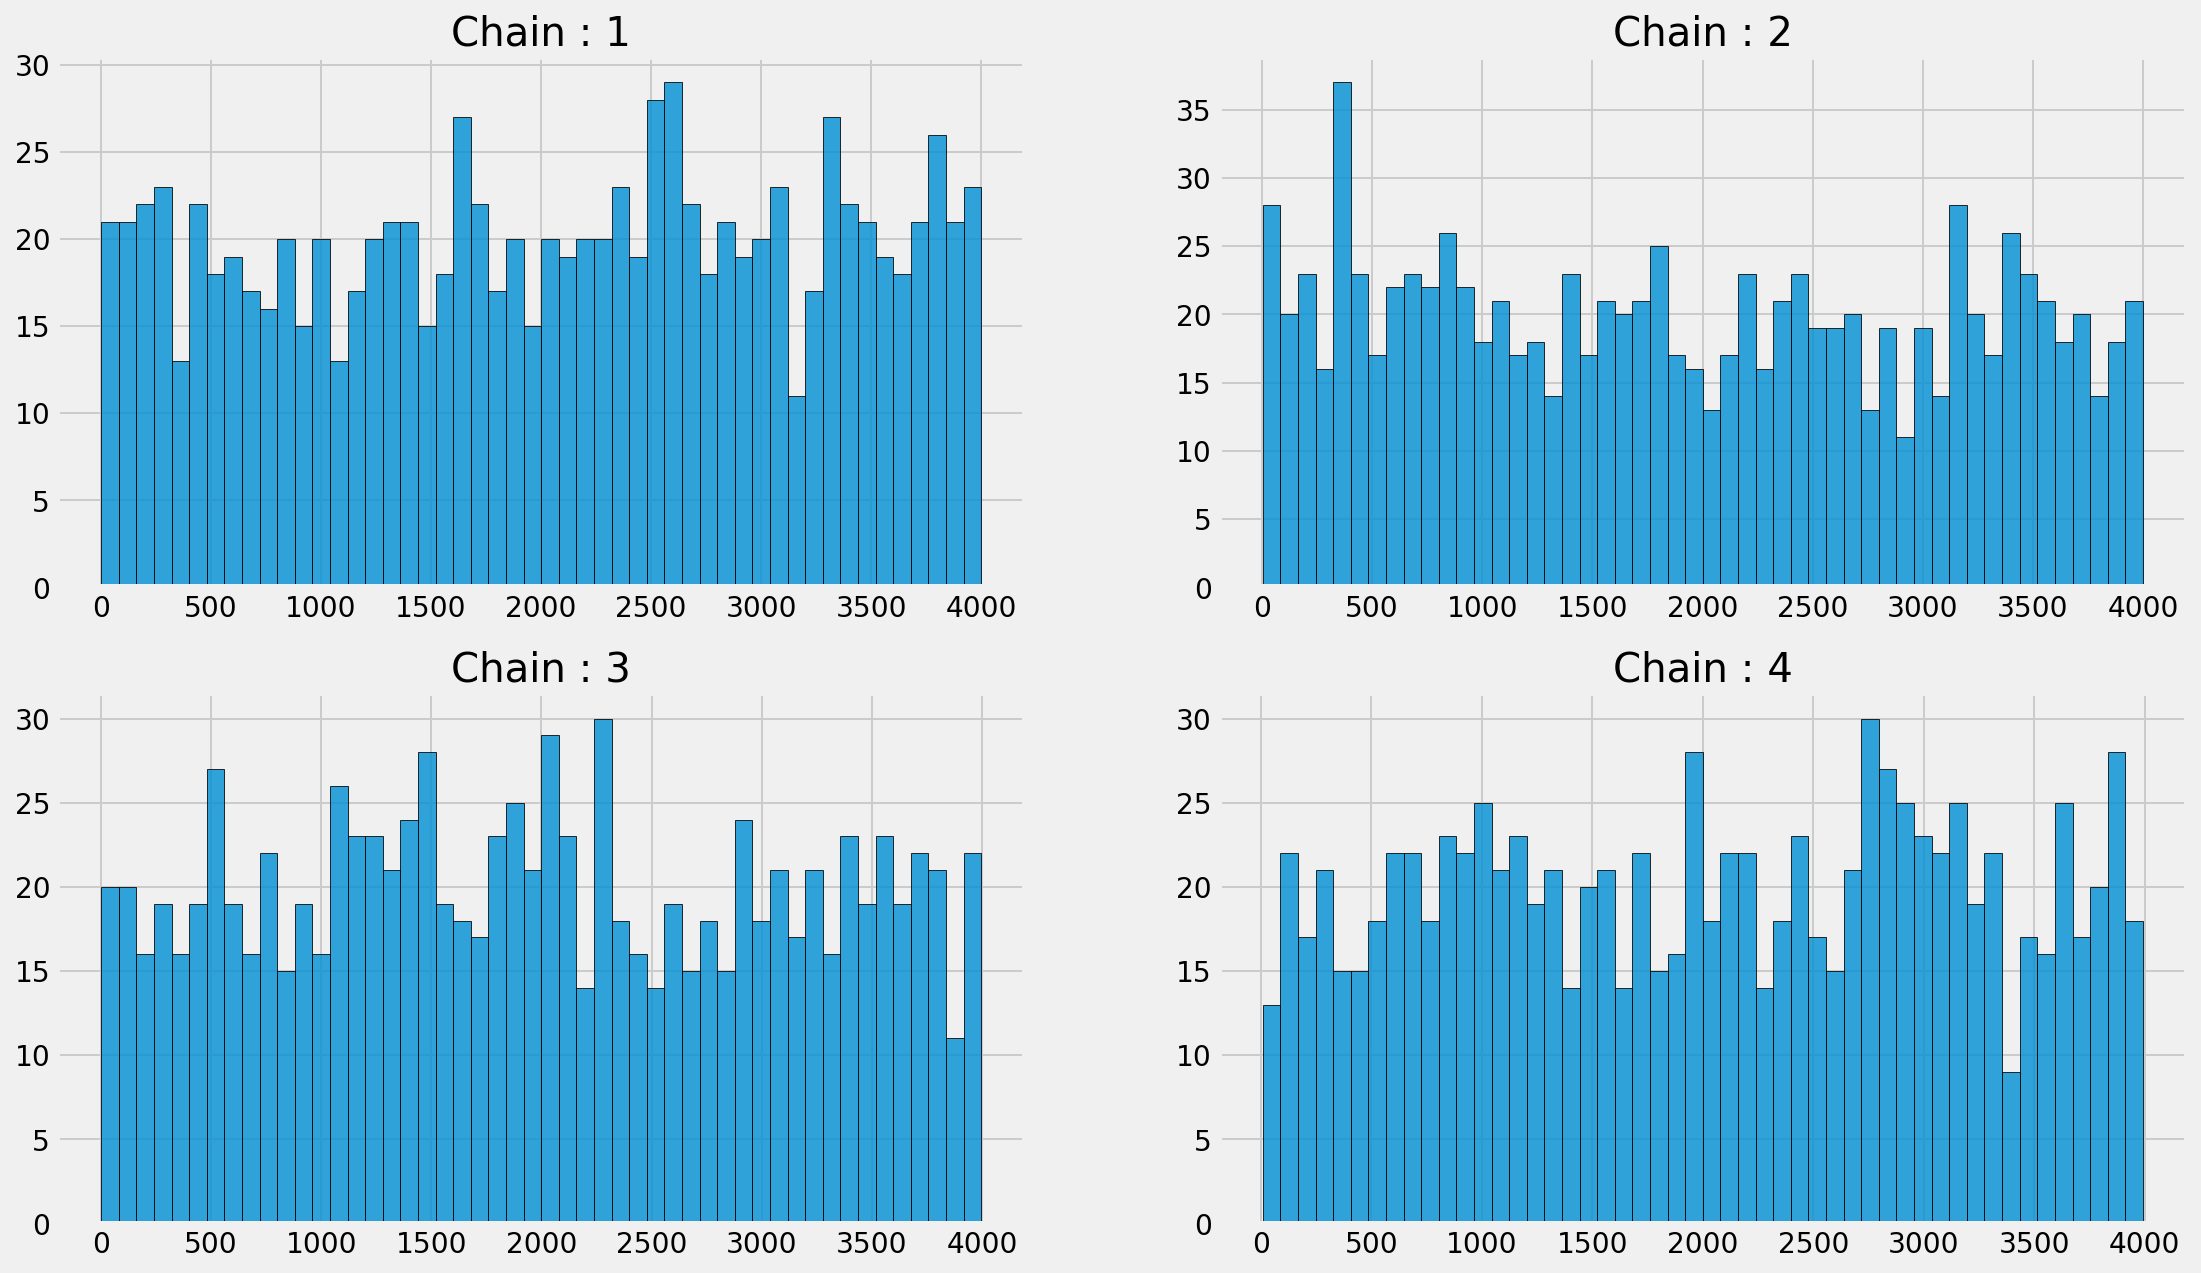

In [15]:
plotutils.rankplot(np.array(trace.get_values(params[0], combine=False)), 4, 2, 2)

Now, we plot the shifted chain example:

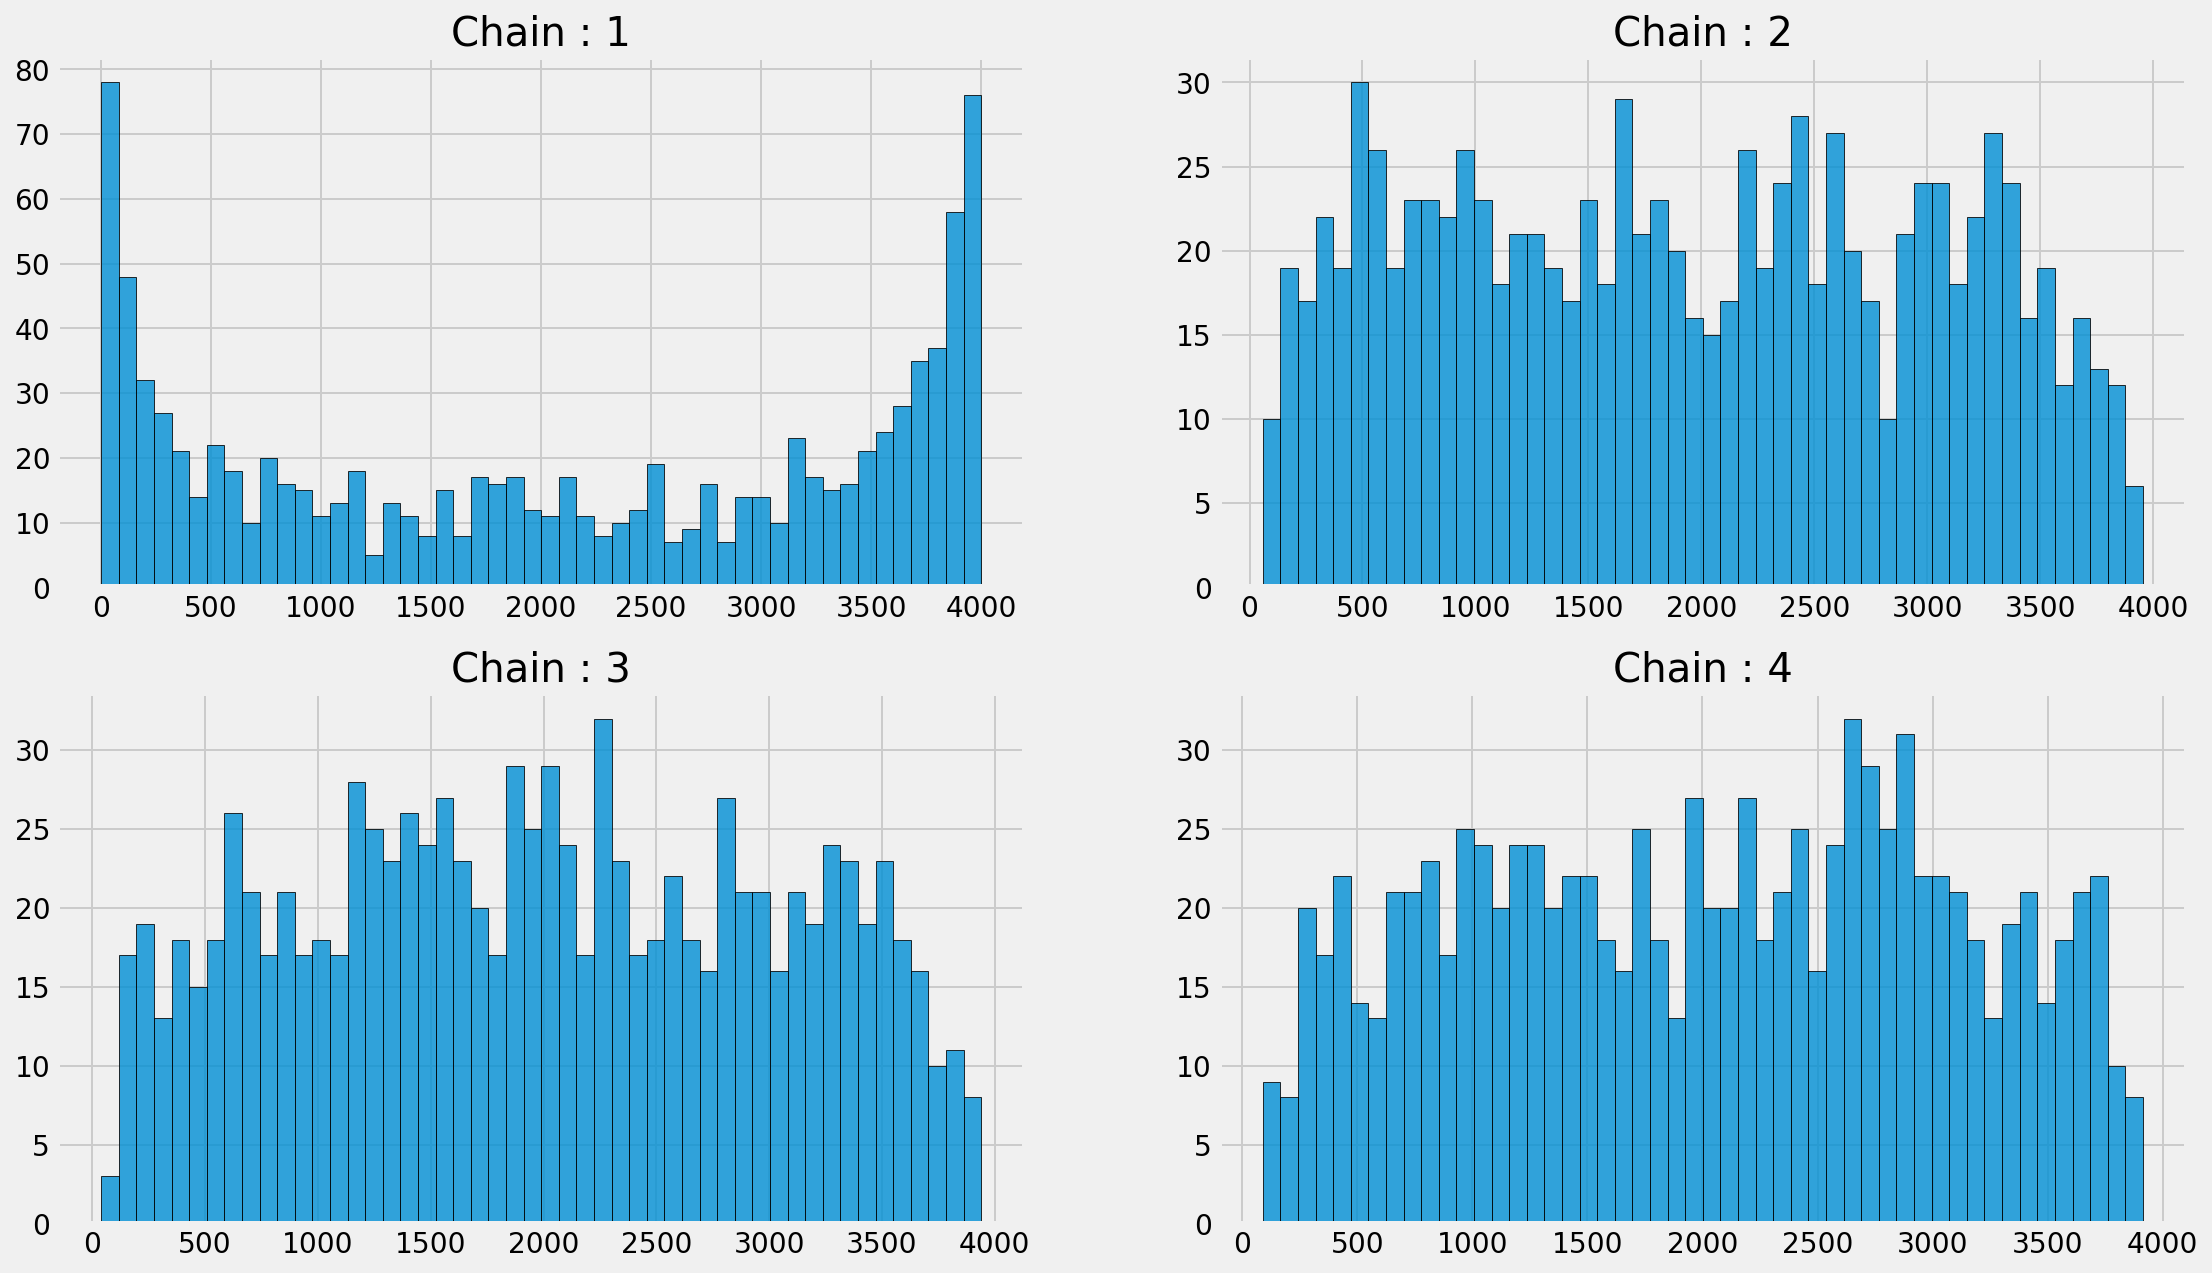

In [16]:
plotutils.rankplot(trace_dvar, 4, 2, 2)

Clearly as it is seen, something is not right with Chain $1$.

# Correlated 2D Gaussian Example

Our test on the standard 1D Gaussian shows that the $\rhat$ is a robust statistic and that zscale histogram and rankplots are equally helpful at diagnosing problems. However, it is also important to stress test these tools in higher dimensions, especially with features that are highly correlated. We want to test if the correlation has any effect on our measurement. 

To do this test, we will consider two scenario -- (i) 2D isotropic Gaussian (ii) correlated 2D Gaussian. The comparison will help us get a good sense of the robustness of these diagnostic tools.

### Sample data

#### Case 1: Isotropic Gaussian

<Figure size 1080x720 with 0 Axes>

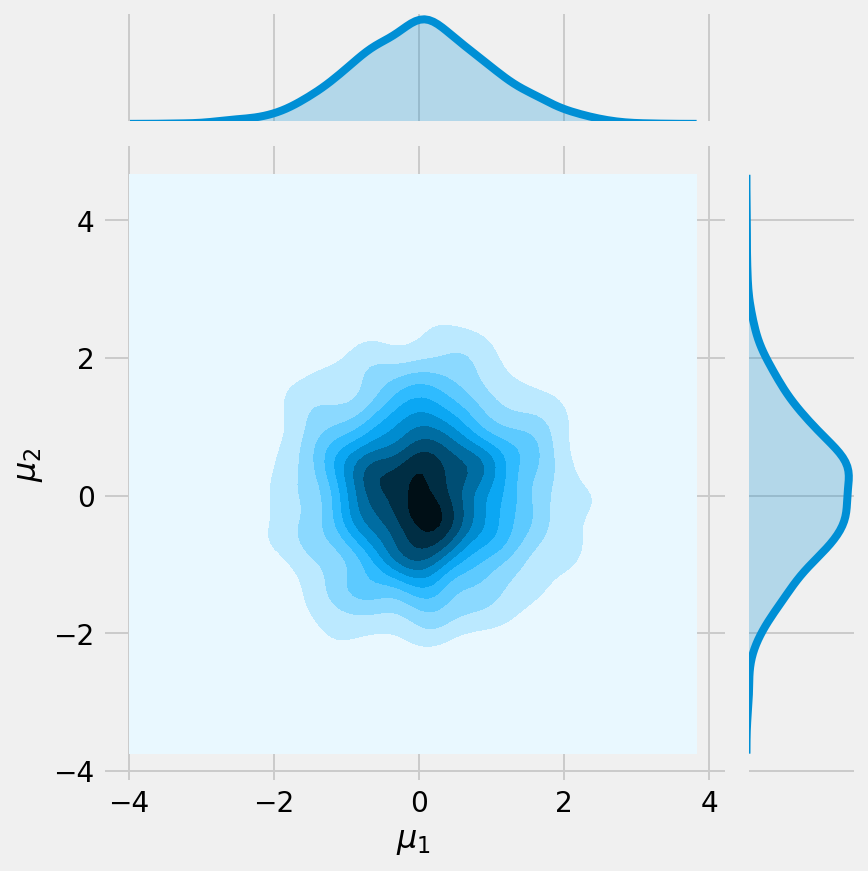

In [5]:
import seaborn as sns
seed = 42
np.random.seed(seed)
mean = np.array([0, 0])
sigma_iso = np.array([[1, 0], [0,1]])
data_isotropic = np.random.multivariate_normal(mean = mean, cov = sigma_iso, size=10_00)

fig = plt.figure(figsize=(15, 10))
f = sns.jointplot(data_isotropic[:,0], data_isotropic[:,1], kind = 'kde')
f.set_axis_labels(r'$\mu_1$', r'$\mu_2$', fontsize=16)

#### Case 2: Correlated features

<Figure size 1080x720 with 0 Axes>

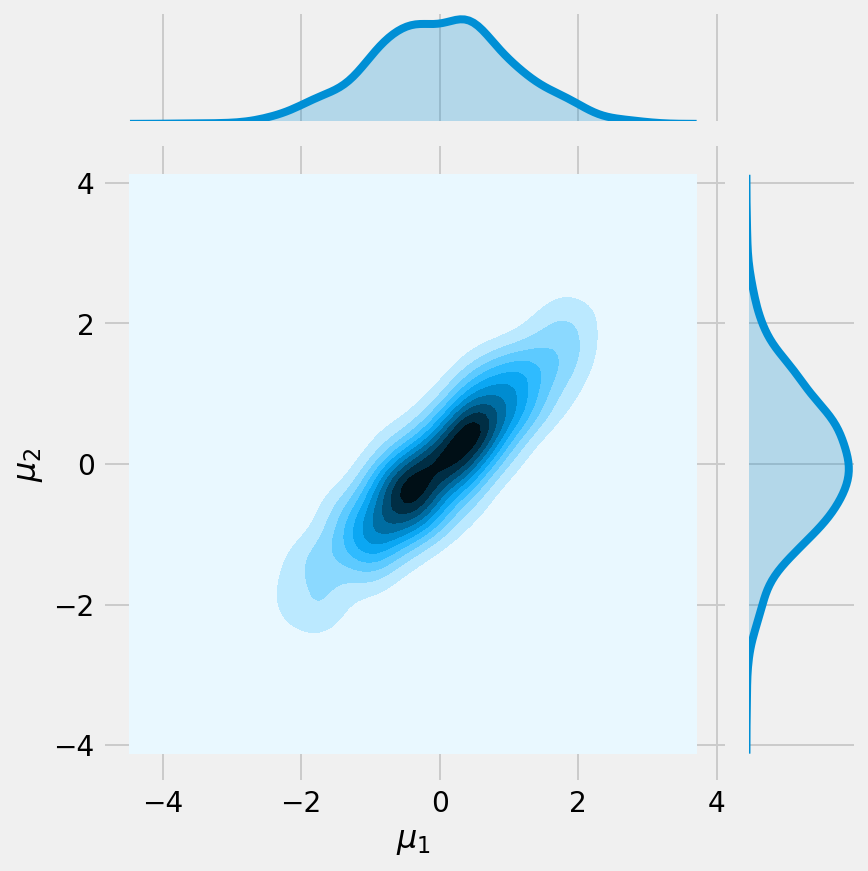

In [6]:
sigma_corr = np.array([[1, .9], [.9,1]])
data_corr = np.random.multivariate_normal(mean = mean, cov = sigma_corr, size=10_00)

fig = plt.figure(figsize=(15, 10))
f = sns.jointplot(data_corr[:,0], data_corr[:,1], kind = 'kde')
f.set_axis_labels(r'$\mu_1$', r'$\mu_2$', fontsize=16)

## Run MCMC sampler

Let's now fit the data $y$ with the following model to be explored by our sampler:

$$
    \mu \sim \mathcal N \left(\begin{bmatrix}
0\\
0
\end{bmatrix}, \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}\right) \\
    y|\theta \sim \mathcal N \left(\begin{bmatrix}
0\\
0
\end{bmatrix}, \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}\right)
$$

In [7]:
params = ["mu"] # parameters to fit for
with pm.Model() as model_isotropic:
    mu = pm.MvNormal("mu", mean, sigma_iso, shape = 2)
    y_obs = pm.MvNormal("y_obs", mean, cov=sigma_iso, observed=data_isotropic)

with model_isotropic:
    trace_isotropic = pm.sample(1_000, chains=4, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:11<00:00, 667.18draws/s] 


In [8]:
params = ["mu"] # parameters to fit for
with pm.Model() as model_corr:
    mu = pm.MvNormal(params[0], mean, sigma_corr, shape = 2)
    y_obs = pm.MvNormal("y_obs", mean, cov=sigma_corr, observed=data_corr)

with model_corr:
    trace_corr = pm.sample(1_000, chains=4, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:15<00:00, 510.96draws/s]


Next, we check the traceplots:

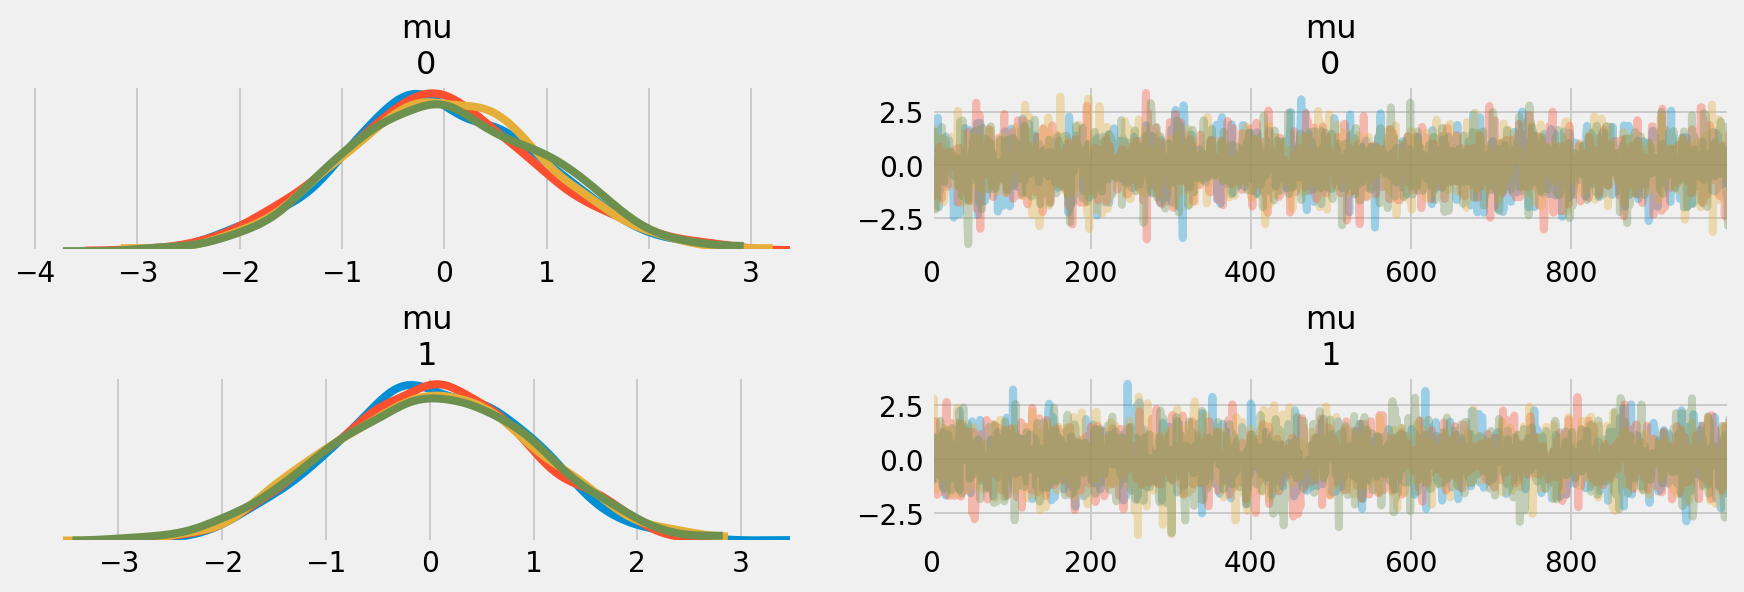

In [8]:
pm.traceplot(trace_isotropic)
plt.show()

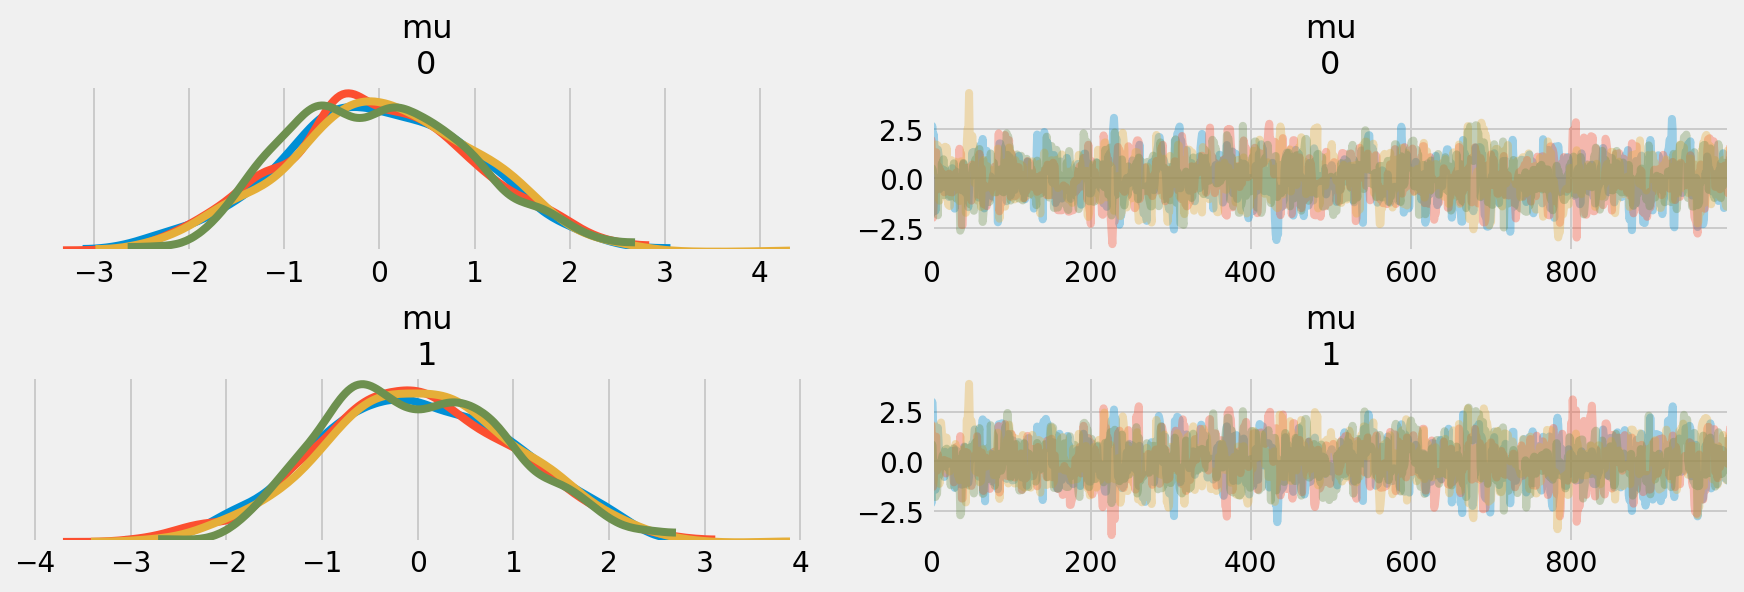

In [9]:
pm.traceplot(trace_corr)
plt.show()

Both cases look converged. 

Now, we will calculate the split $\rhat$ diagnostic for both cases, which has been the conventional diagnostic that is widely used:

In [28]:
trace_iso_mu1 = np.array(trace_isotropic.get_values('mu', combine = False))[:,:,0]
trace_iso_mu2 = np.array(trace_isotropic.get_values('mu', combine = False))[:,:,1]

trace_corr_mu1 = np.array(trace_corr.get_values('mu', combine = False))[:,:,0]
trace_corr_mu2 = np.array(trace_corr.get_values('mu', combine = False))[:,:,1]

In [32]:
print("Traditional Rhat values for isotropic case:")
print("-------")
rhat_split_iso_mu1 = utils.rhat(trace_iso_mu1, param=params[0], split=True)
rhat_split_iso_mu2 = utils.rhat(trace_iso_mu2, param=params[0], split=True)
print(f"mu1: {rhat_split_iso_mu1}")
print(f"mu2: {rhat_split_corr_mu2}")

Traditional Rhat values for isotropic case:
-------
mu1: 0.9996643175367814
mu2: 1.00082955861856


In [33]:
print("Traditional Rhat values for correlated case:")
print("-------")
rhat_split_corr_mu1 = utils.rhat(trace_corr_mu1, param=params[0], split=True)
rhat_split_corr_mu2 = utils.rhat(trace_corr_mu2, param=params[0], split=True)
print(f"mu1: {rhat_split_corr_mu1}")
print(f"mu2: {rhat_split_corr_mu2}")

Traditional Rhat values for correlated case:
-------
mu1: 1.0003259978850854
mu2: 1.00082955861856


### Injecting fake chains
Since we have already generated two samples with different covariance matrices, we can inject chain of one into another and check whether both the tradtional metric and the new metric can catch it.

#### Case 1: Isotropic Gaussian

Here, we inject one of the correlated chains into the isotropic traces.

In [87]:
# extract trace array from pymc3's MultiTrace object
trace_dvar = np.array(trace_isotropic.get_values(params[0], combine=False)) 
# replace third chain of trace array with the fake chain
trace_dvar[2, :] = np.array(trace_corr.get_values(params[0], combine=False))[0, :]

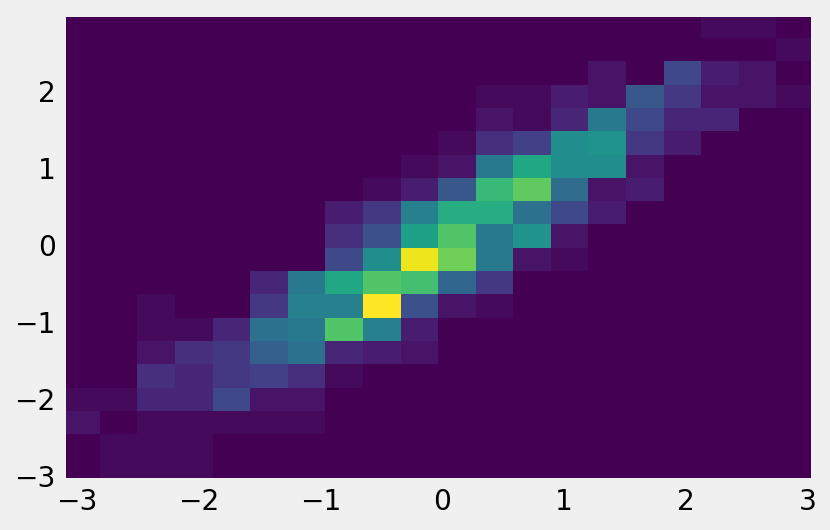

In [37]:
i = 2
plt.hist2d(trace_dvar[i][:,0], trace_dvar[i][:,1], bins = 20);

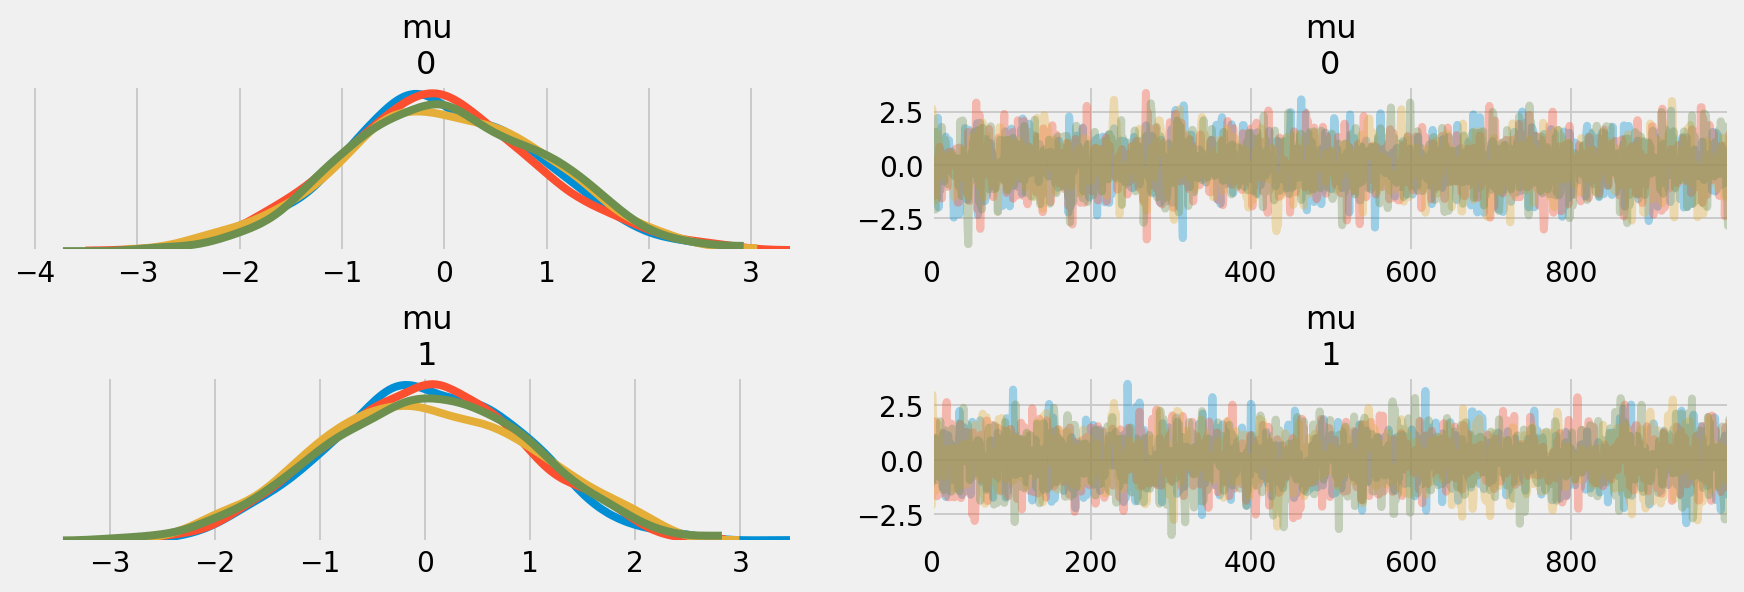

In [38]:
trace_dvar_dict = {params[0]:trace_dvar}
pm.traceplot(trace_dvar_dict)
plt.show()

The traceplots look converged. Now we run the traditional rhat statistic on this synthetic model:

In [46]:
print("Traditional Rhat values for correlated injected into isotropic case:")
trace_iso_injected_corr = {}
for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    trace_tmp = trace_dvar[:,:,i]
    trace_iso_injected_corr[string] = trace_tmp
    rhat_split_tmp = utils.rhat(trace_tmp, param=params[0], split=True)
    print(string + f": {rhat_split_tmp}")

Traditional Rhat values for correlated injected into isotropic case:
mu1: 1.0003877641683883
mu2: 1.0012895284681869


We do not see any noticeable shift in the value of the parameters.

### Rank Normalized Results

In [43]:
pm.summary(trace_isotropic)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,-0.020813,0.992094,0.014173,-1.977386,1.892419,4298.557104,1.000134
mu__1,0.019129,0.980653,0.013716,-1.878284,1.870558,4082.857640,0.999639


#### We calculate the rank normalized $\rhat$ and the rank normalized folded $\rhat$:

In [53]:
def rhat_results(d):
    #
    # returns table of rhat values for parameter in dict (d)
    #
    index = [
        "standard",
        "split",
        "ranked",
        "folded"
    ]
    df_rhats = pd.DataFrame(index=index)
    for param_name, param_chains in d.items():
        rhat_standard = utils.rhat(param_chains, split=False)
        rhat_split = utils.rhat(param_chains, split=True)
        rhat_rank = utils.rank_rhat(param_chains)
        rhat_folded = utils.folded_split_rhat(param_chains)
        df_rhats[param_name] = [rhat_standard, rhat_split, rhat_rank, rhat_folded]

    return df_rhats

In [54]:
rhat_results(trace_iso_injected_corr)

,mu1,mu2
standard,1.000112,0.999660
split,1.000388,1.001290
ranked,1.000390,1.001319
folded,1.000027,1.003355


Here we see that the ranked or the folded $\rhat$ were not able to pick up on this injected chain at all. Given that we injected a really skewed 2D Gaussian, we can safely say that the newly defined ranked and folded rank $\rhat$ values cannot distinguish between isotropic and correlated cases. Hence, even this statistic can give the impression that the chains are sampling the same underlying distribution and that the chains converged, whereas in reality this may not be the case.

### Rankplots
Next, we check rankplots to see whether this diagnostic gives any indication of the injection. 

In [68]:
import importlib
importlib.reload(plotutils)

<module 'plotutils' from 'C:\\Users\\tanve\\Documents\\APMTH207\\Project\\pyhat\\codes\\plotutils.py'>

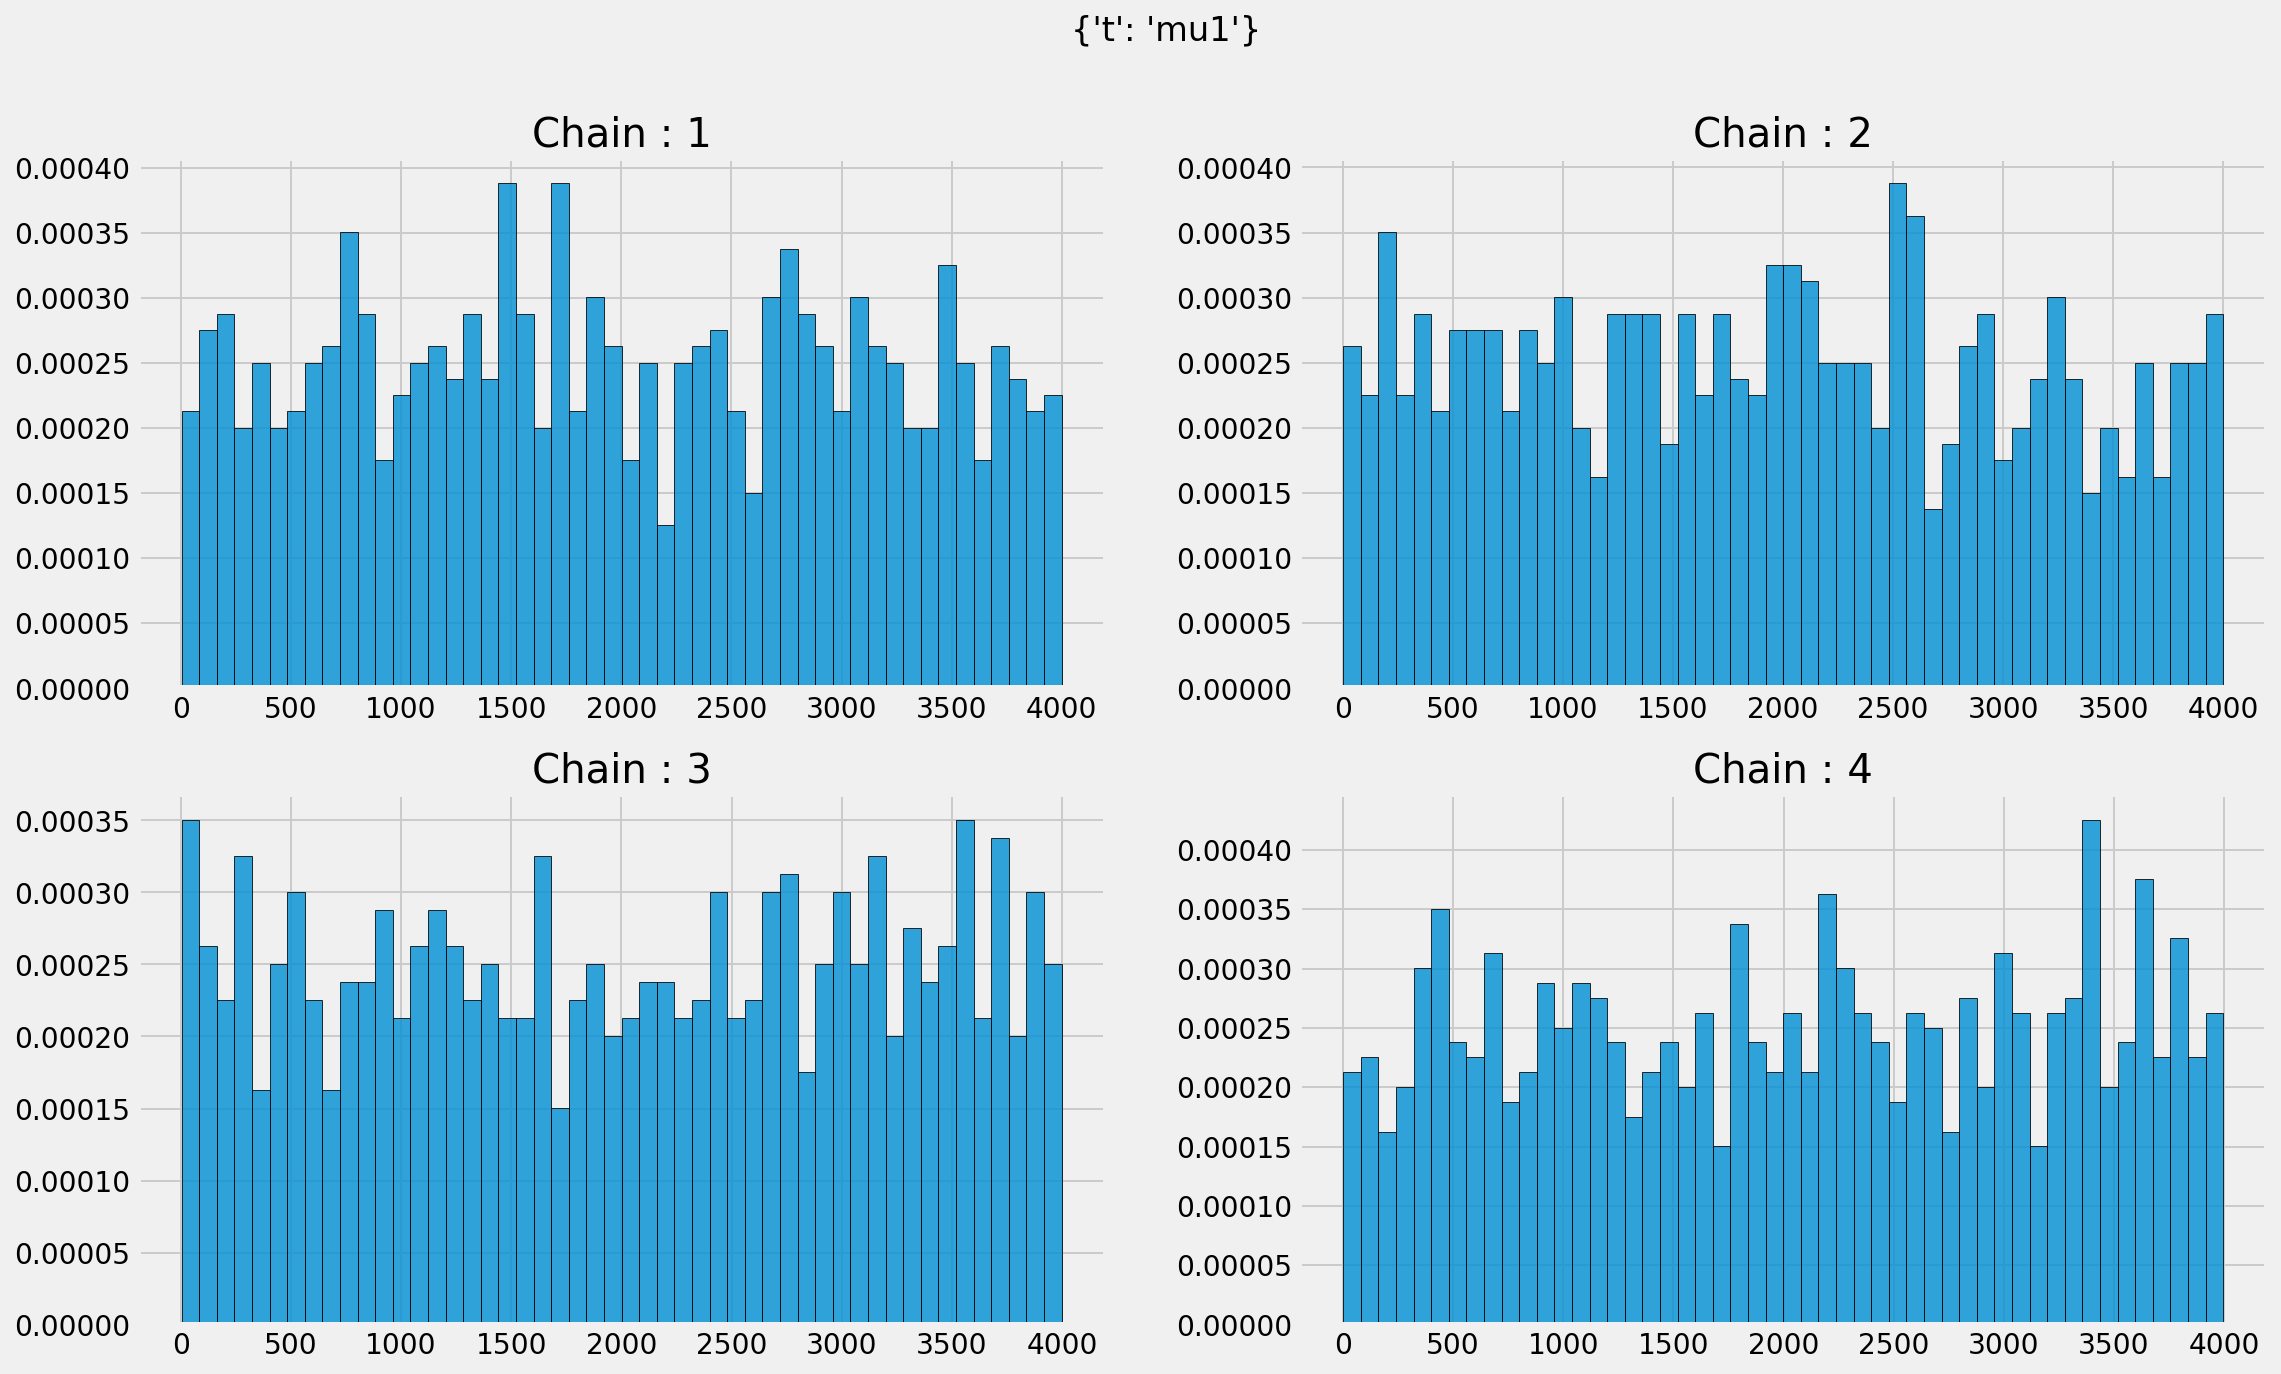

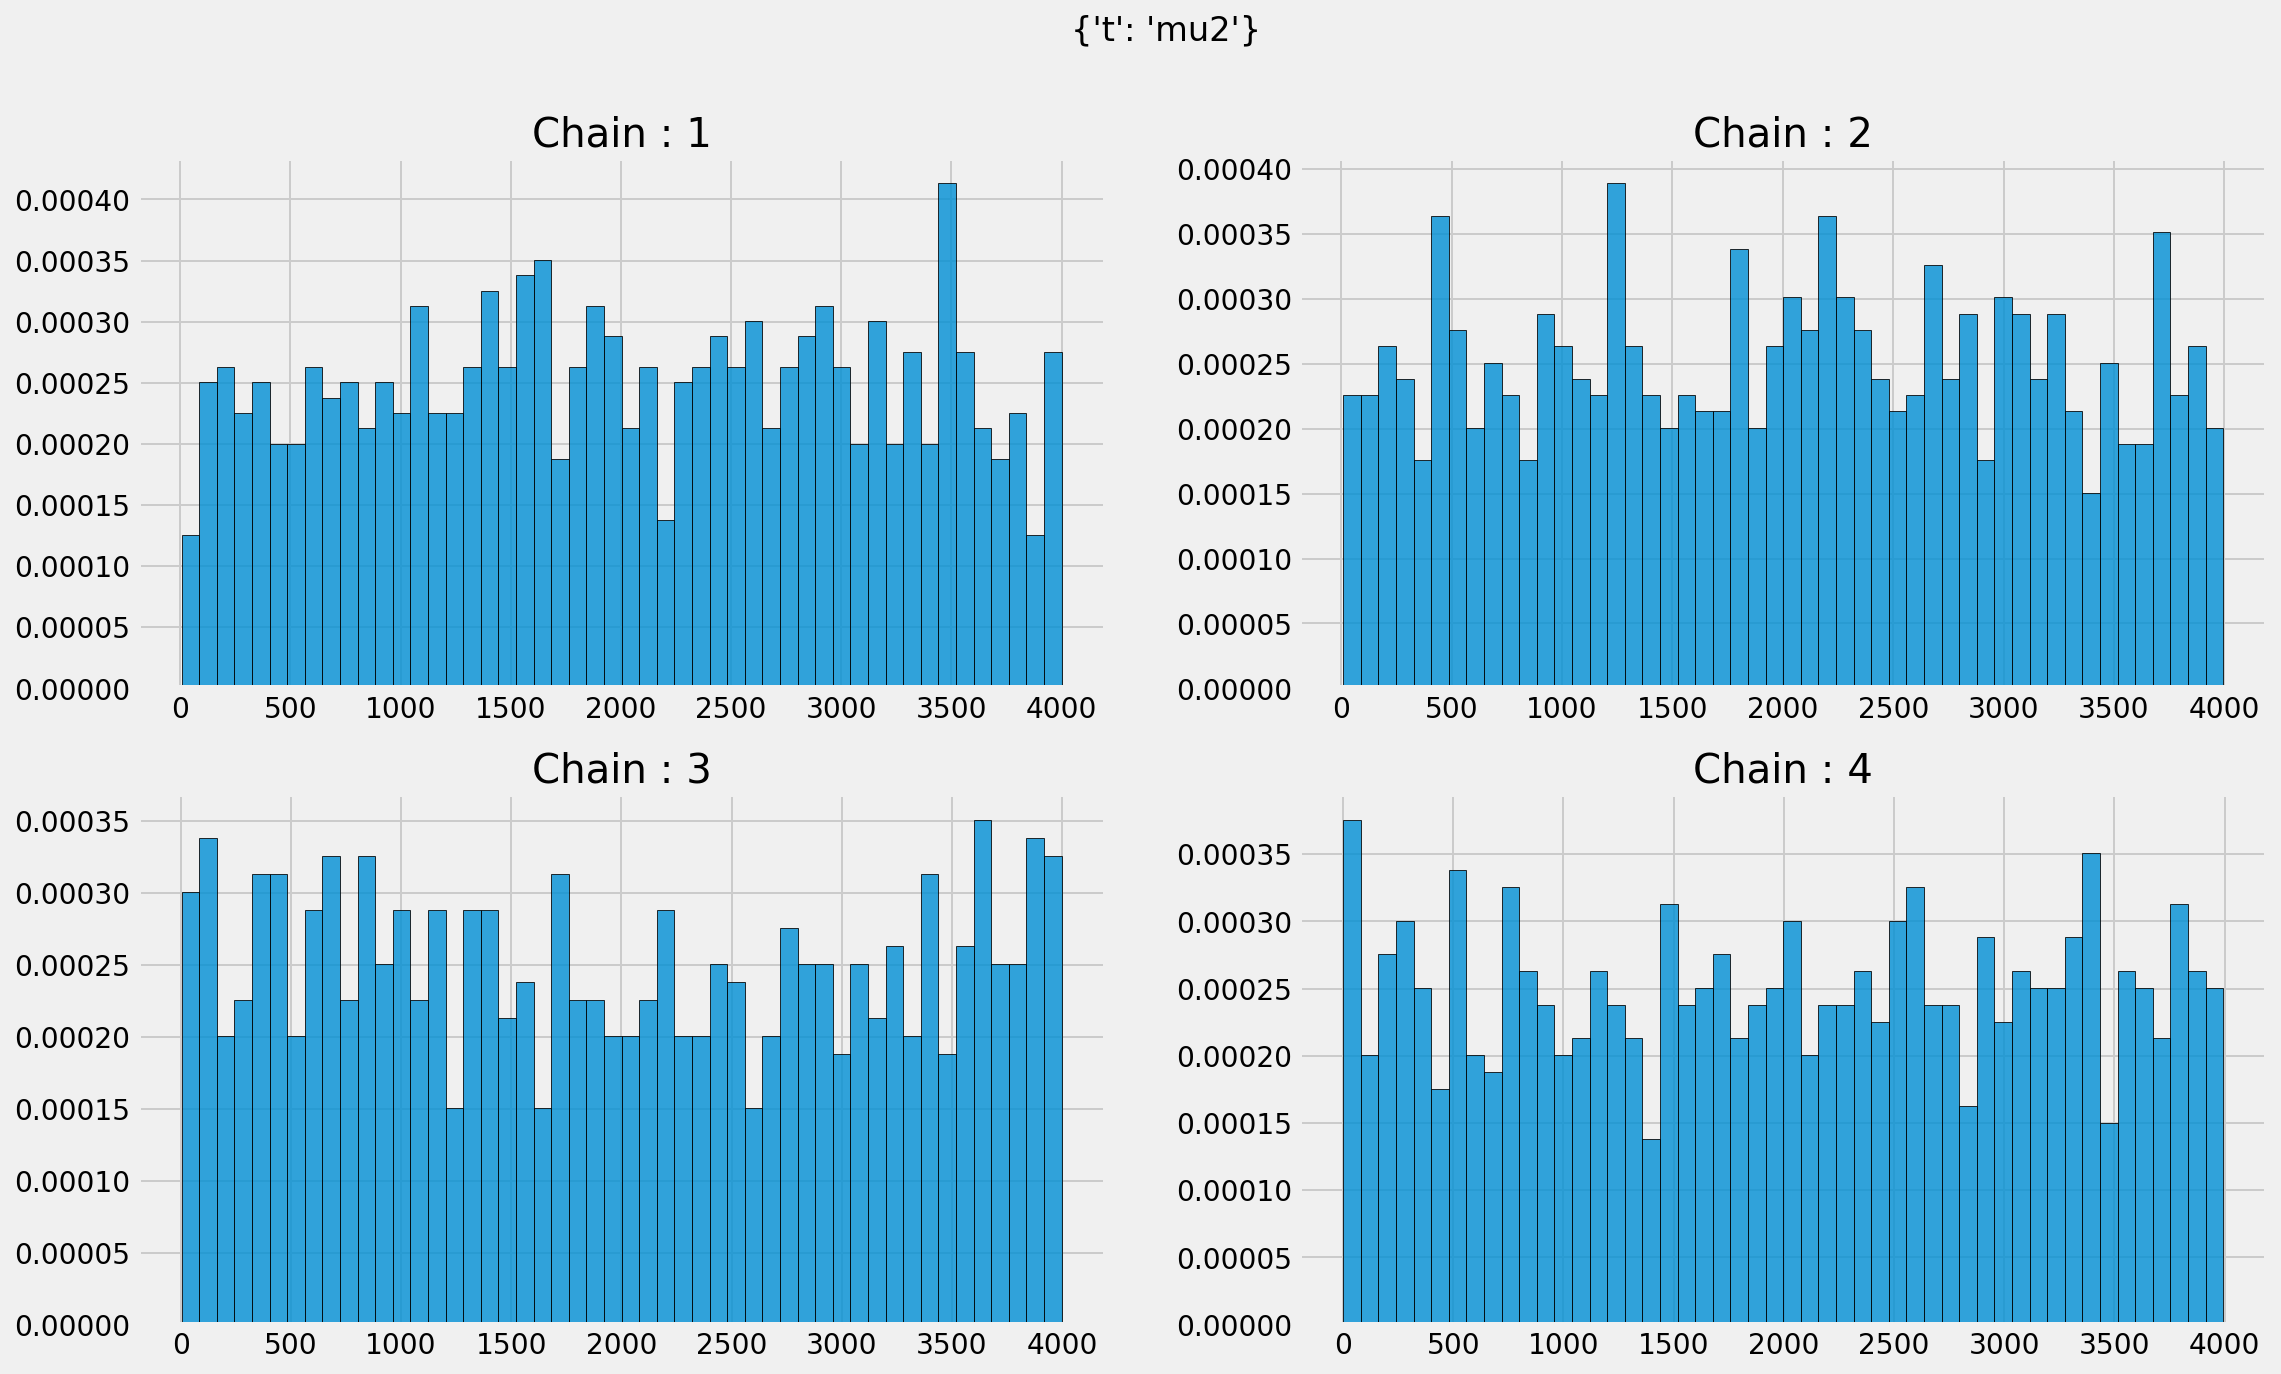

In [69]:
for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    plotutils.rankplot(trace_dvar[:,:,i], 4, 2, 2, t = string)

The ranked chains do not look different for either of the features. Hence, even the rankplot is unable to diagnose this injection. This result makes sense given the definition of $\rhat$. The $\rhat$ statistic is calculated on a per parameter basis. So in a sense, it is a calculation over marginalization of chains and since the marginalization does not carry any information of correlation, the statistic fails to understand this injection. Although this is beyond the scope of our project, we think that implementing an $\rhat$ definition that encapsulates all the parameters in all the chains to yield a single number could be a good way to probe correlationness, in addition to calculating $\rhat$ by parameters. Of course, the alternative is to look at correlation plots of chains by parameter but that can quickly become cumbersome as we scale the number of parameters and chains.  

### Inject different covariance matrix

Now we will try injecting a chain from a completely different Gaussian with a different covariance matrix, both in diagonal and off-diagonal terms.

The fake Gaussian looks like this:

<Figure size 1080x720 with 0 Axes>

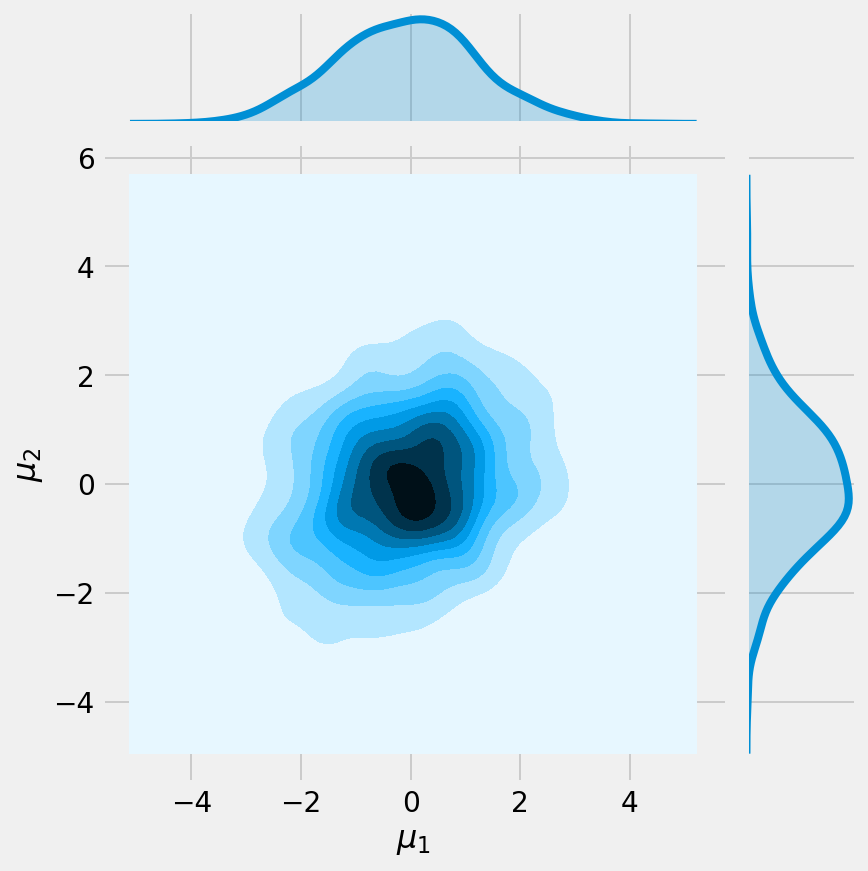

In [71]:
import seaborn as sns
seed = 42
np.random.seed(seed)
mean = np.array([0, 0])
sigma_fake = np.array([[1.7, .5], [.5, 1.7]])
data_fake = np.random.multivariate_normal(mean = mean, cov = sigma_fake, size=10_00)

fig = plt.figure(figsize=(15, 10))
f = sns.jointplot(data_fake[:,0], data_fake[:,1], kind = 'kde')
f.set_axis_labels(r'$\mu_1$', r'$\mu_2$', fontsize=16)

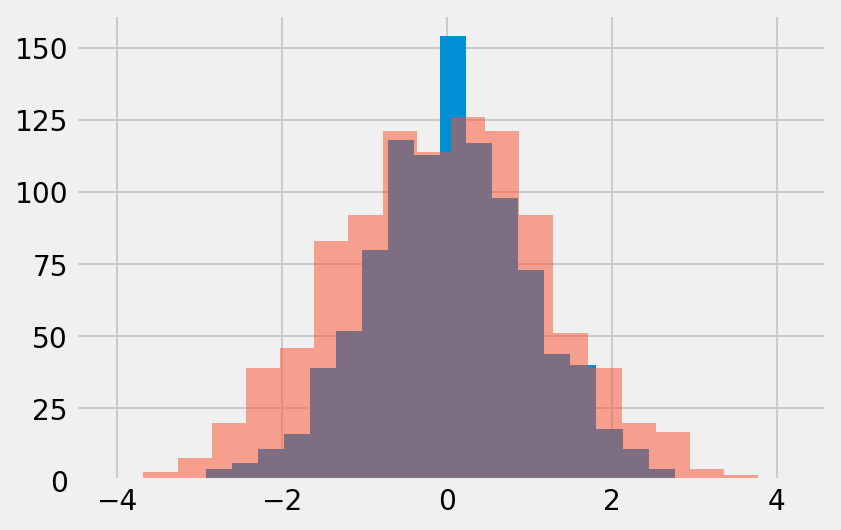

In [72]:
plt.hist(data_isotropic[:,0], bins = 20);
plt.hist(data_fake[:,0], bins = 20, alpha = 0.5);

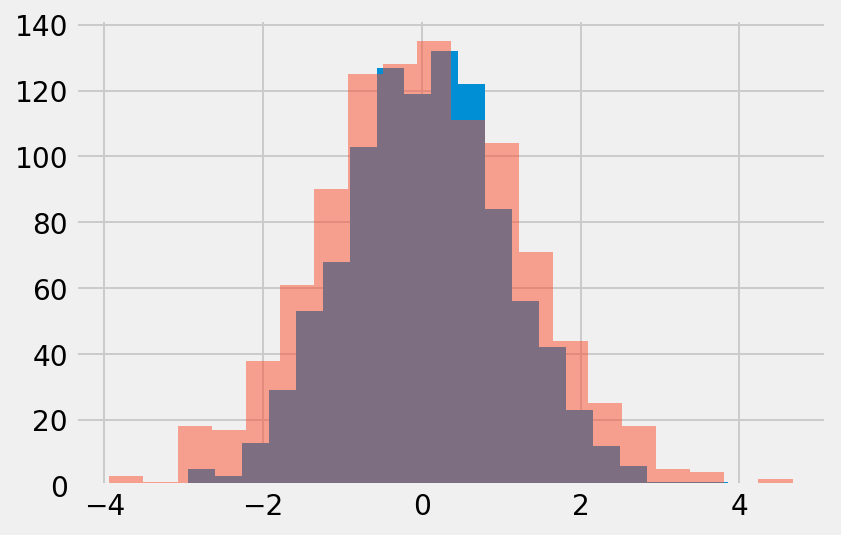

In [73]:
plt.hist(data_isotropic[:,1], bins = 20);
plt.hist(data_fake[:,1], bins = 20, alpha = 0.5);

In [75]:
params = ["mu"] # parameters to fit for
with pm.Model() as model_fake:
    mu = pm.MvNormal(params[0], mean, sigma_iso, shape = 2)
    y_obs = pm.MvNormal("y_obs", mu, cov=sigma_fake, observed=data_isotropic)

with model_fake:
    trace_fake = pm.sample(1_000, chains=2, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:14<00:00, 272.62draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000209C28A55C0>,
      dtype=object)

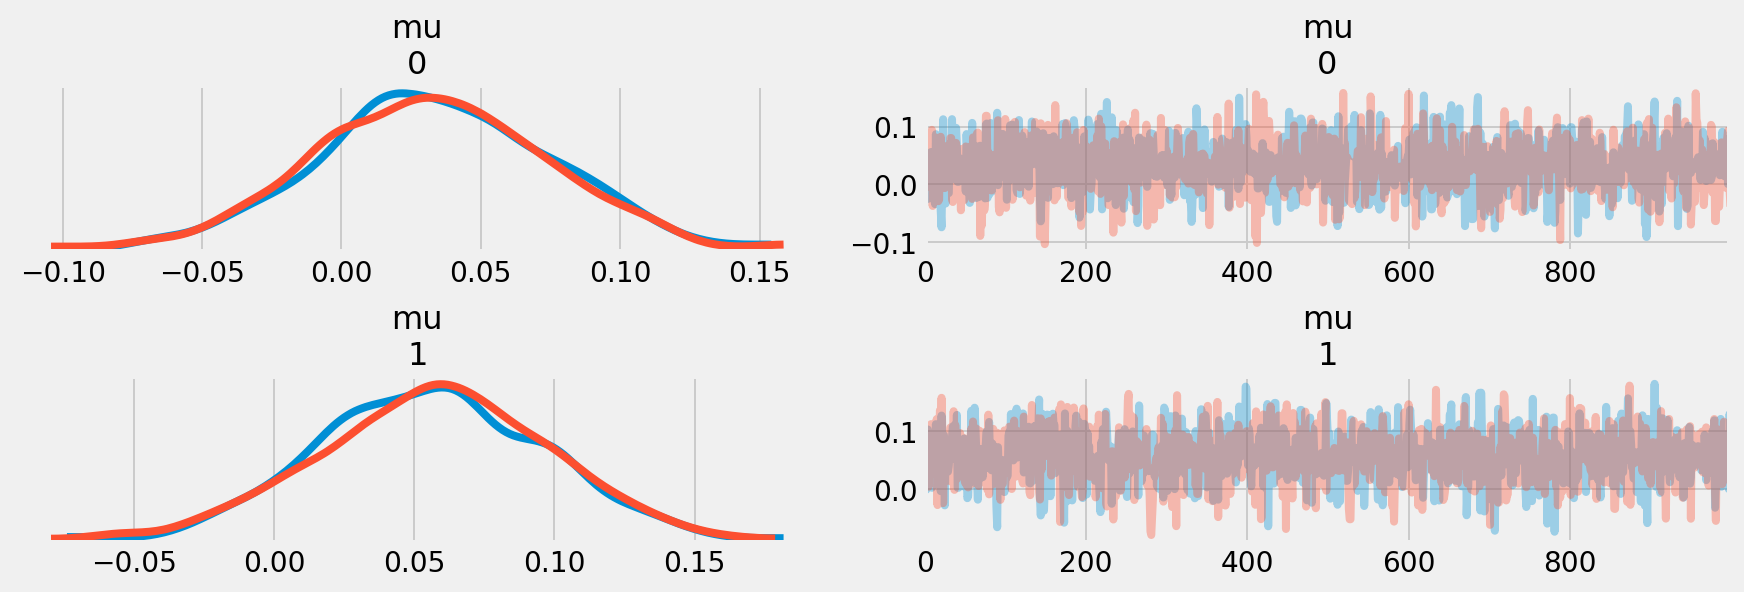

In [76]:
pm.traceplot(trace_fake)

In [77]:
# extract trace array from pymc3's MultiTrace object
trace_dvar = np.array(trace_isotropic.get_values(params[0], combine=False)) 
# replace third chain of trace array with the fake chain
trace_dvar[0, :] = np.array(trace_fake.get_values(params[0], combine=False))[0, :]

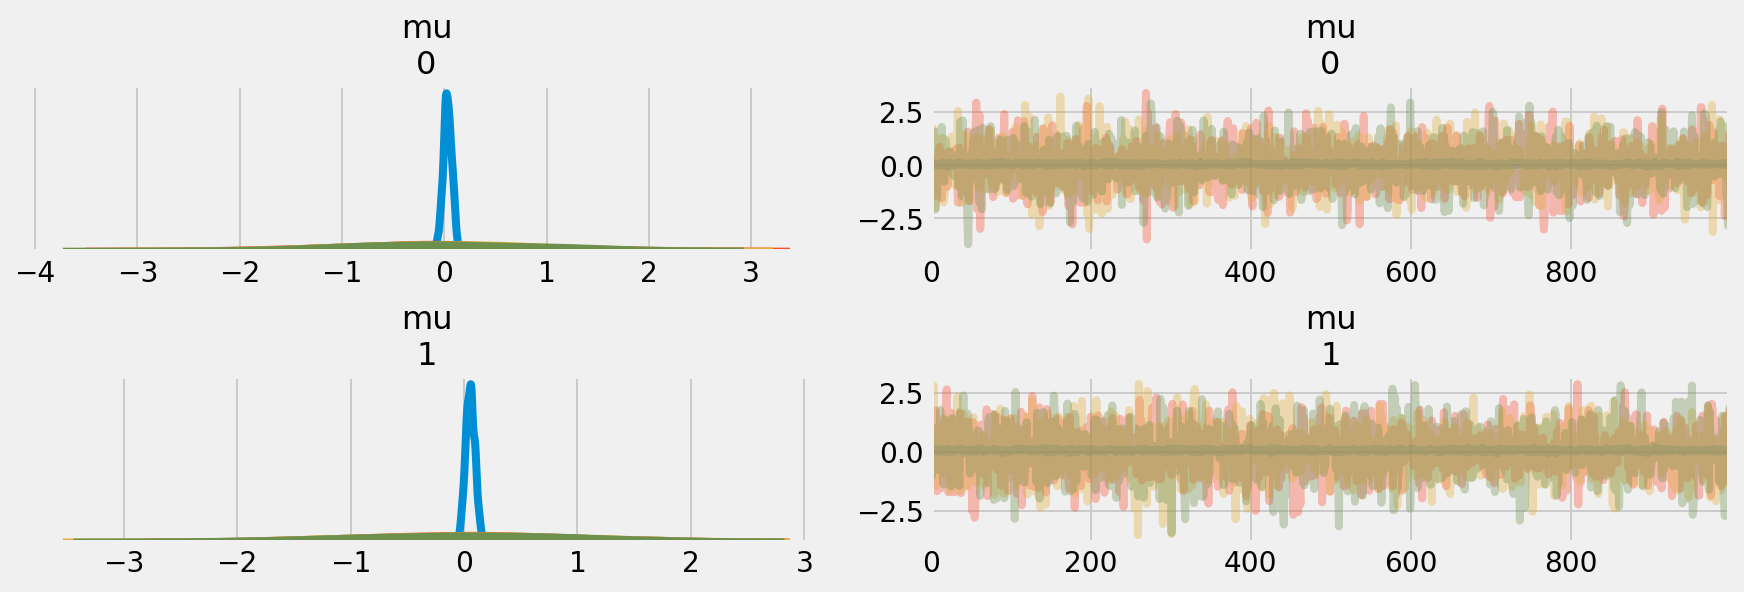

In [80]:
trace_dvar_dict = {params[0]:trace_dvar}
pm.traceplot(trace_dvar_dict)
plt.show()

In [81]:
trace_iso_injected_diff = {}
for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    trace_tmp = trace_dvar[:,:,i]
    trace_iso_injected_diff[string] = trace_tmp
    rhat_split_tmp = utils.rhat(trace_tmp, param=params[0], split=True)
    print(string + f": {rhat_split_tmp}")

mu1: 1.0001884629052293
mu2: 1.0013741152862827


In [82]:
rhat_results(trace_iso_injected_diff)

,mu1,mu2
standard,1.000698,0.999861
split,1.000188,1.001374
ranked,1.000696,1.001092
folded,1.416524,1.415595


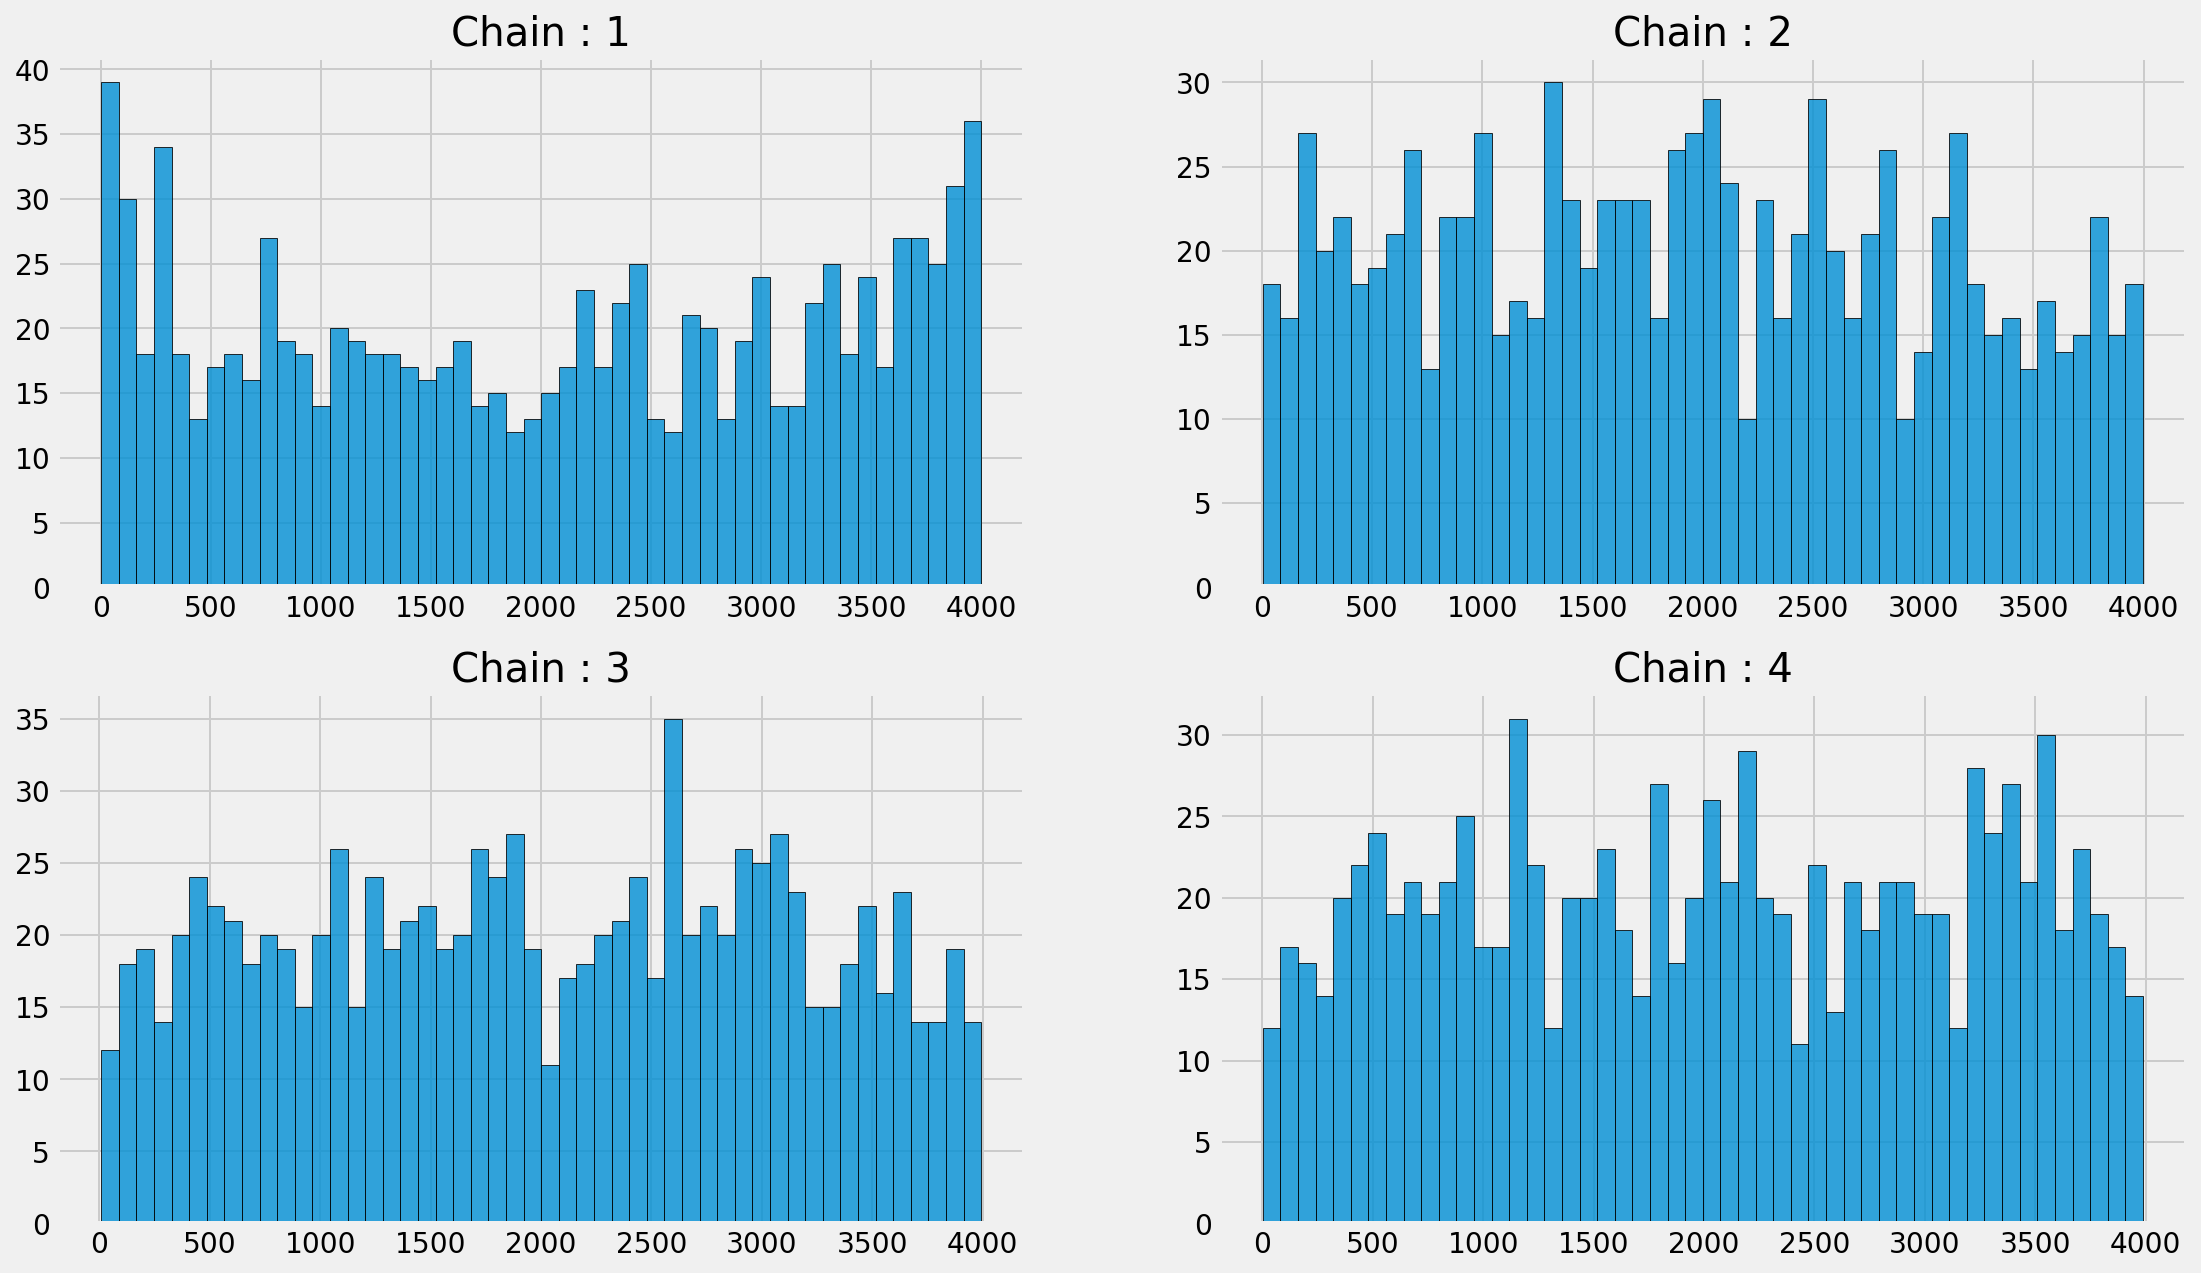

In [318]:
plotutils.rankplot(trace_dvar[:,:,0], 4, 2, 2)

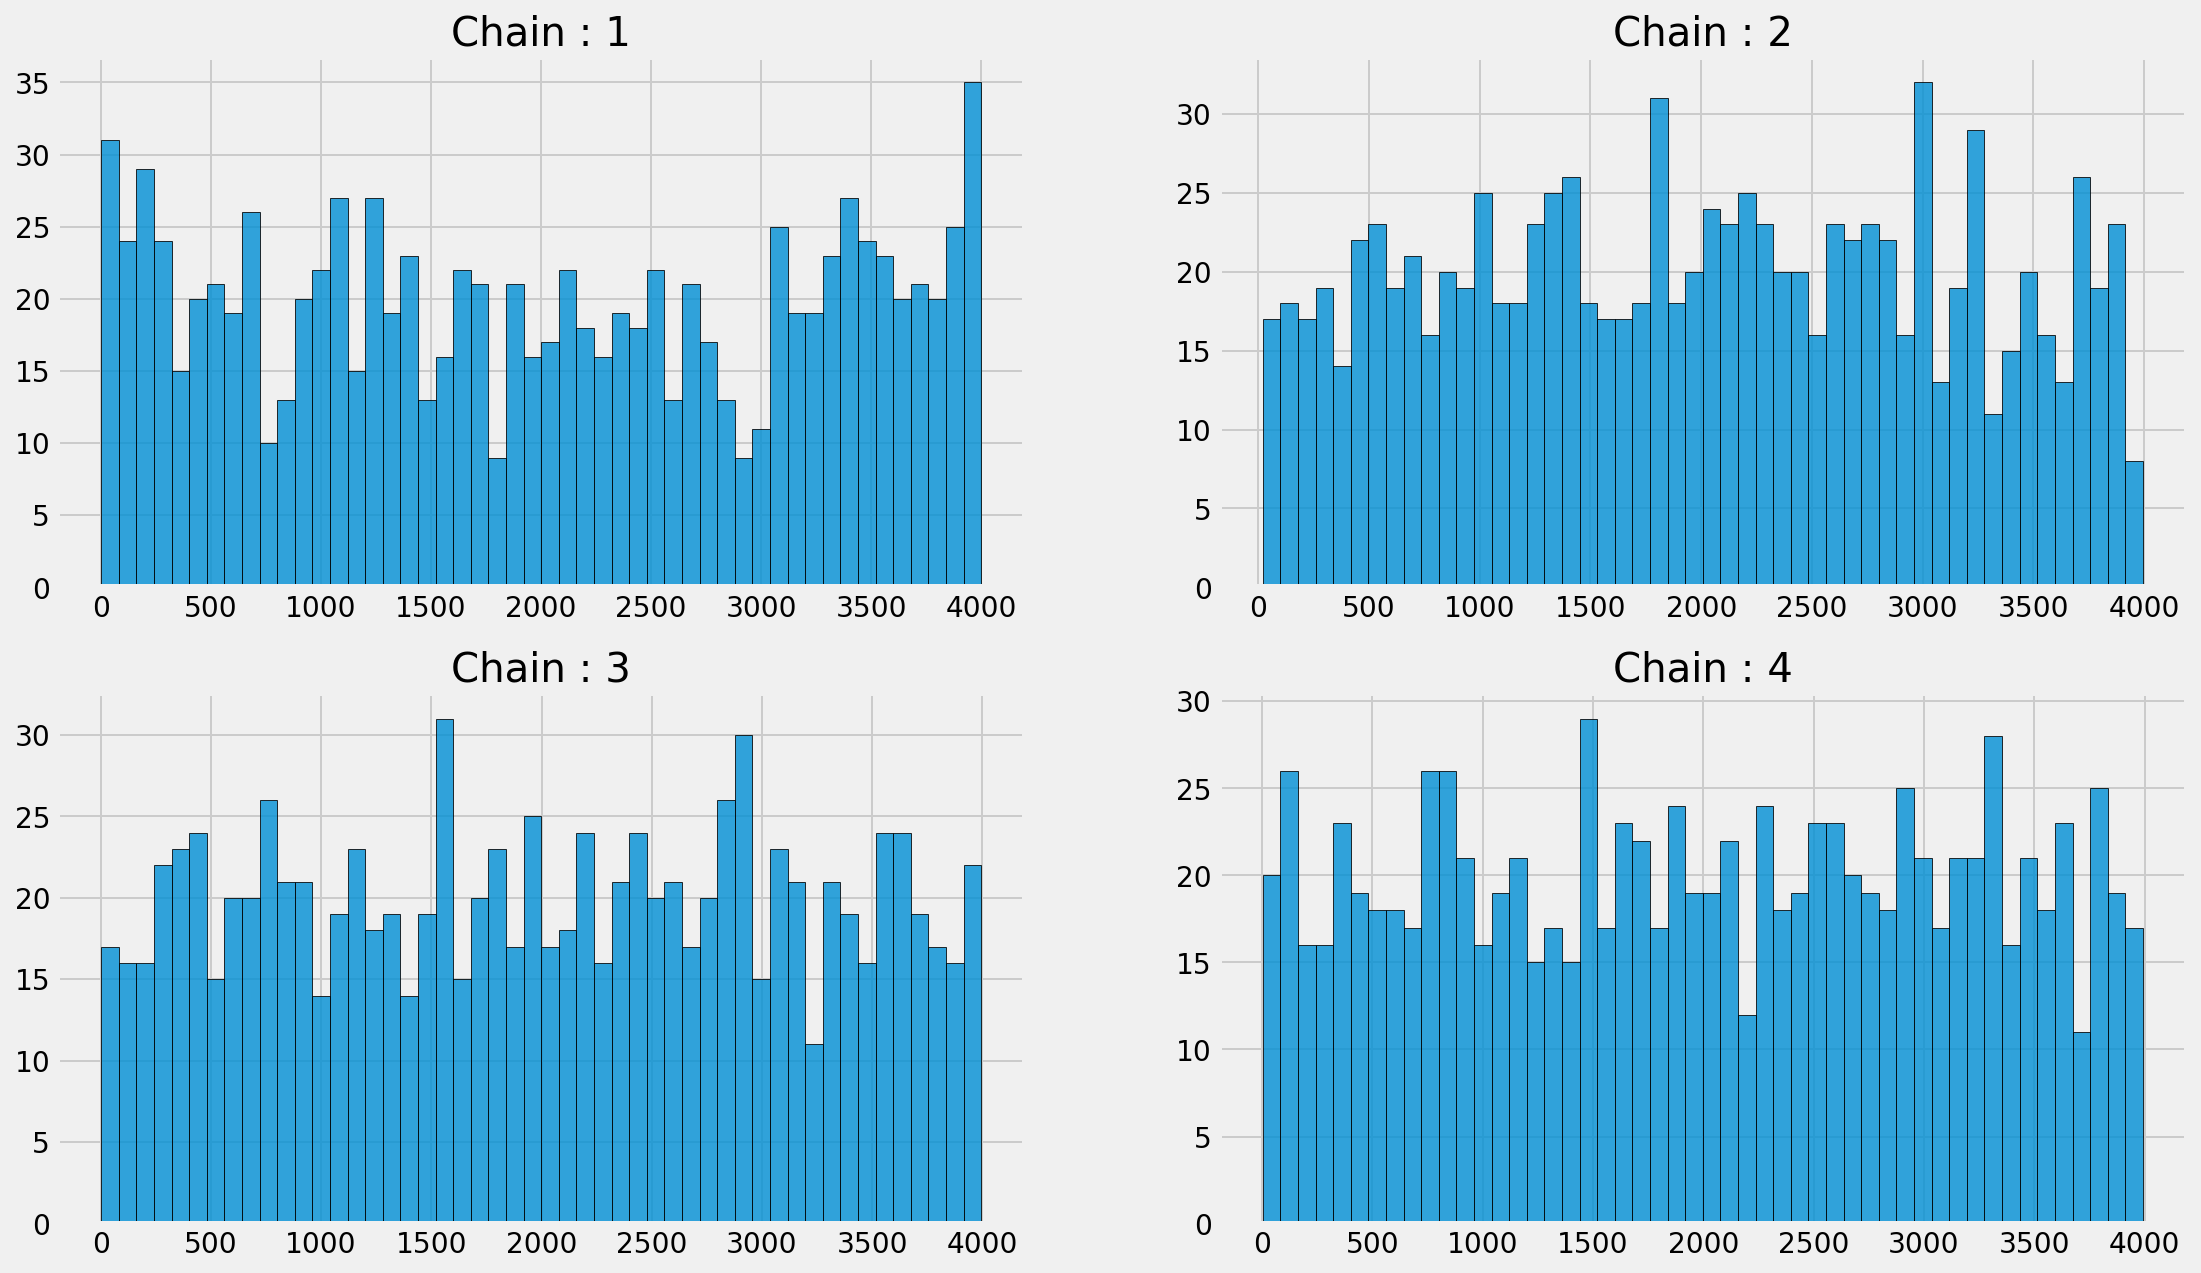

In [319]:
plotutils.rankplot(trace_dvar[:,:,1], 4, 2, 2)

### Rankplots
Next, we check rankplots to see whether this diagnostic gives any indication of the injection. 

In [85]:
import importlib
importlib.reload(plotutils)

<module 'plotutils' from 'C:\\Users\\tanve\\Documents\\APMTH207\\Project\\pyhat\\codes\\plotutils.py'>

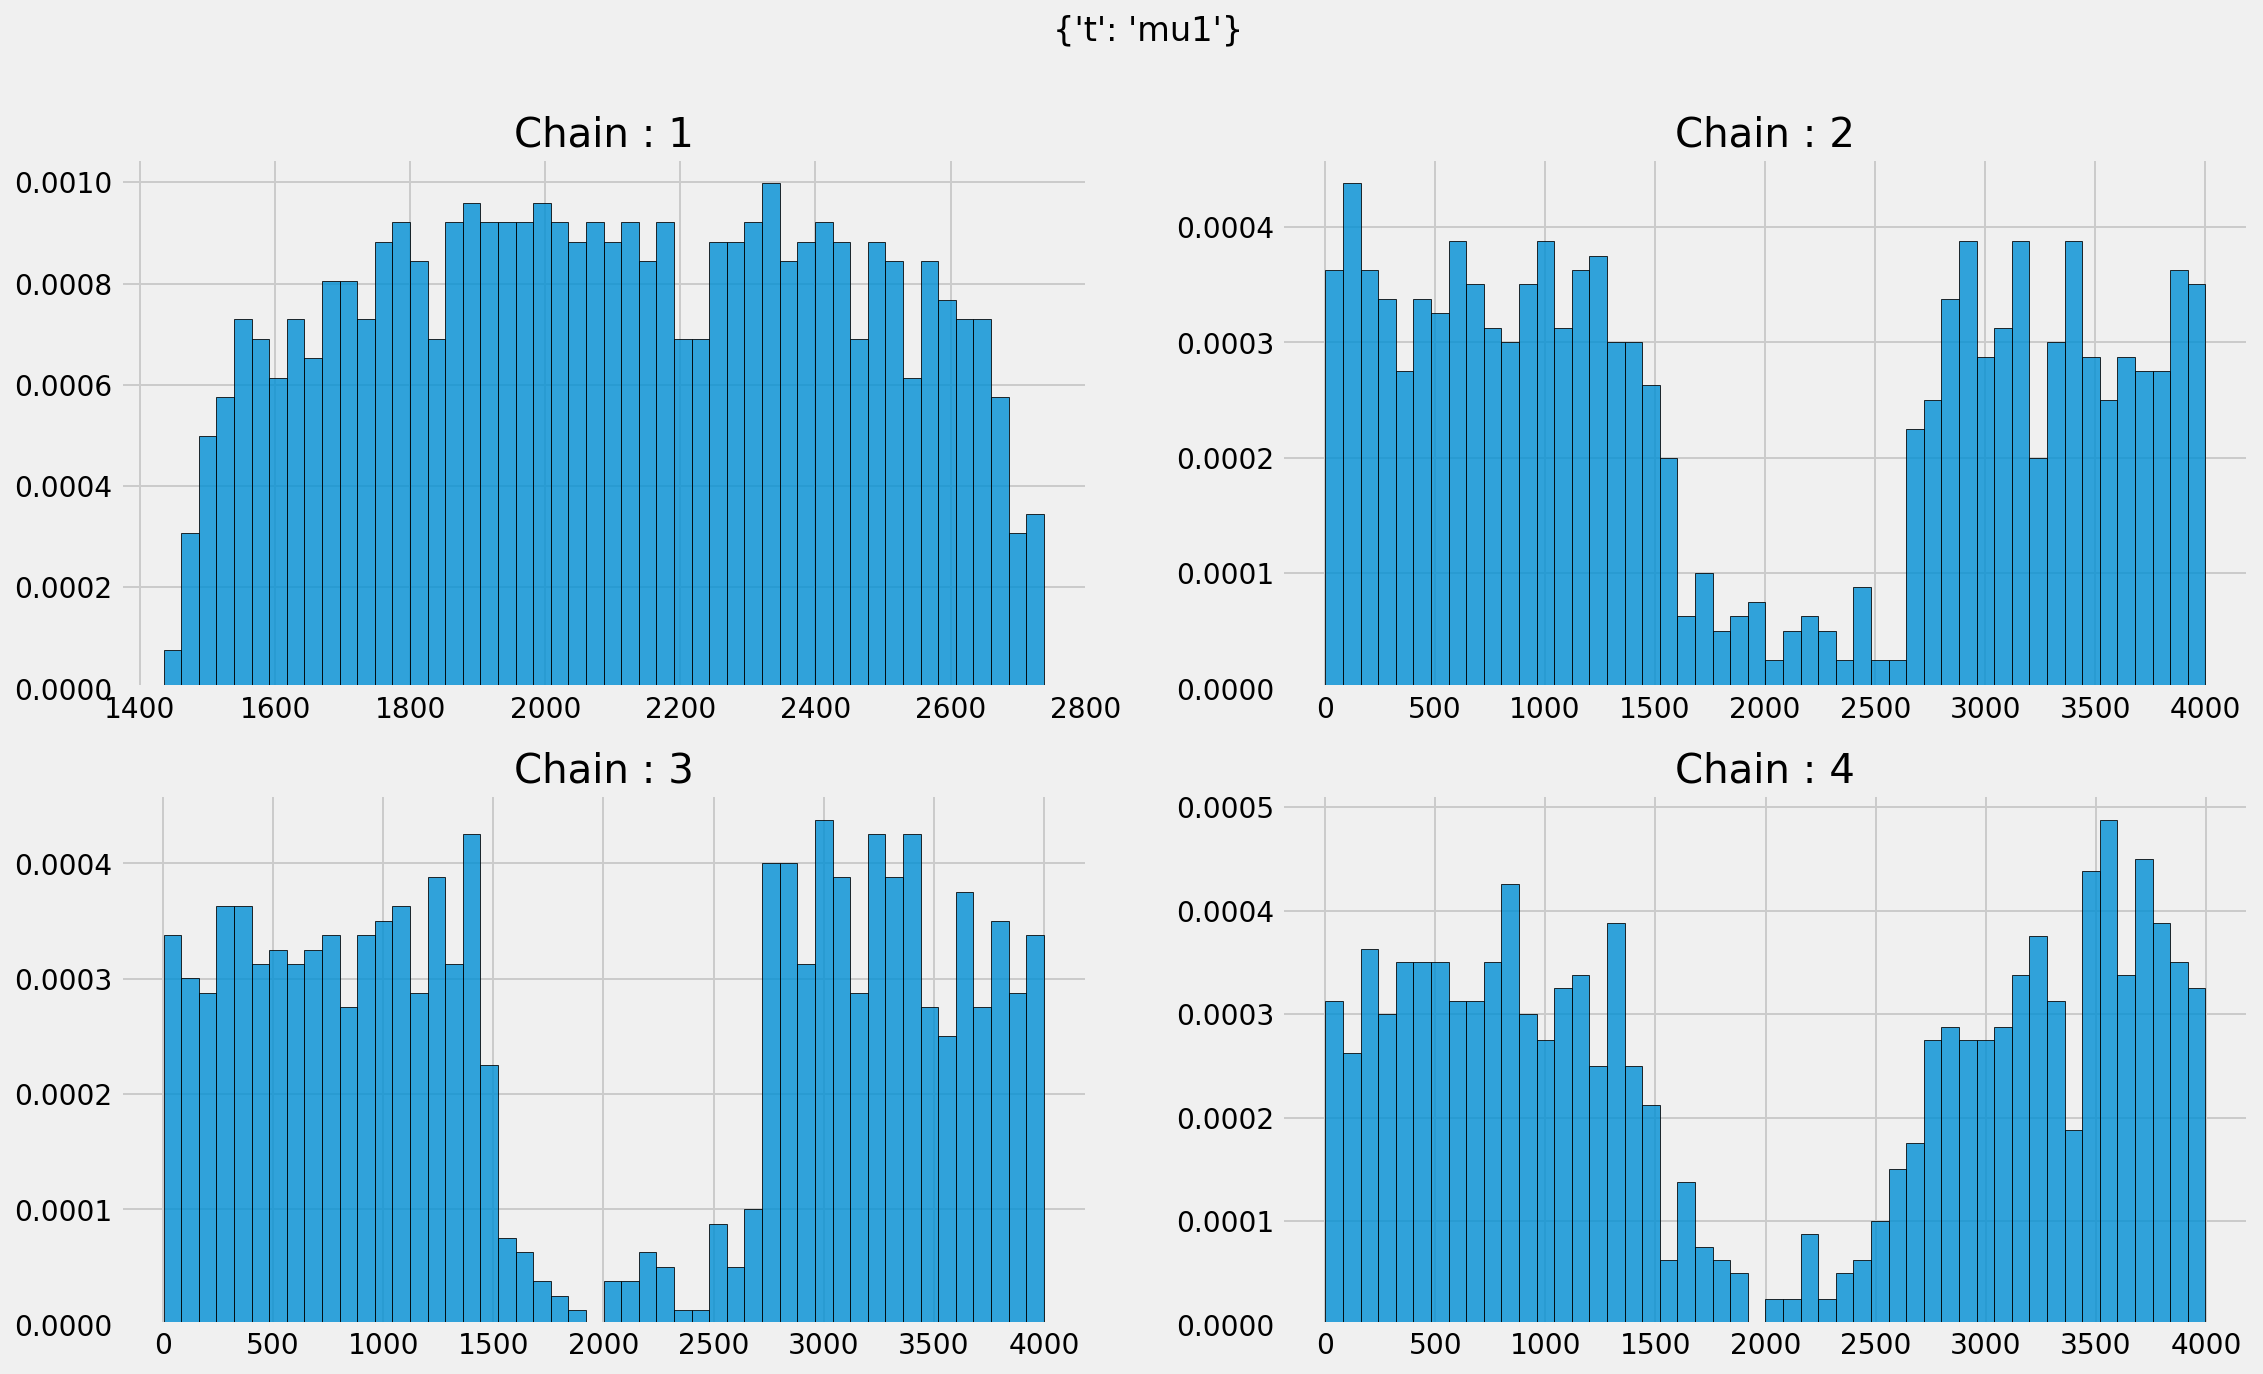

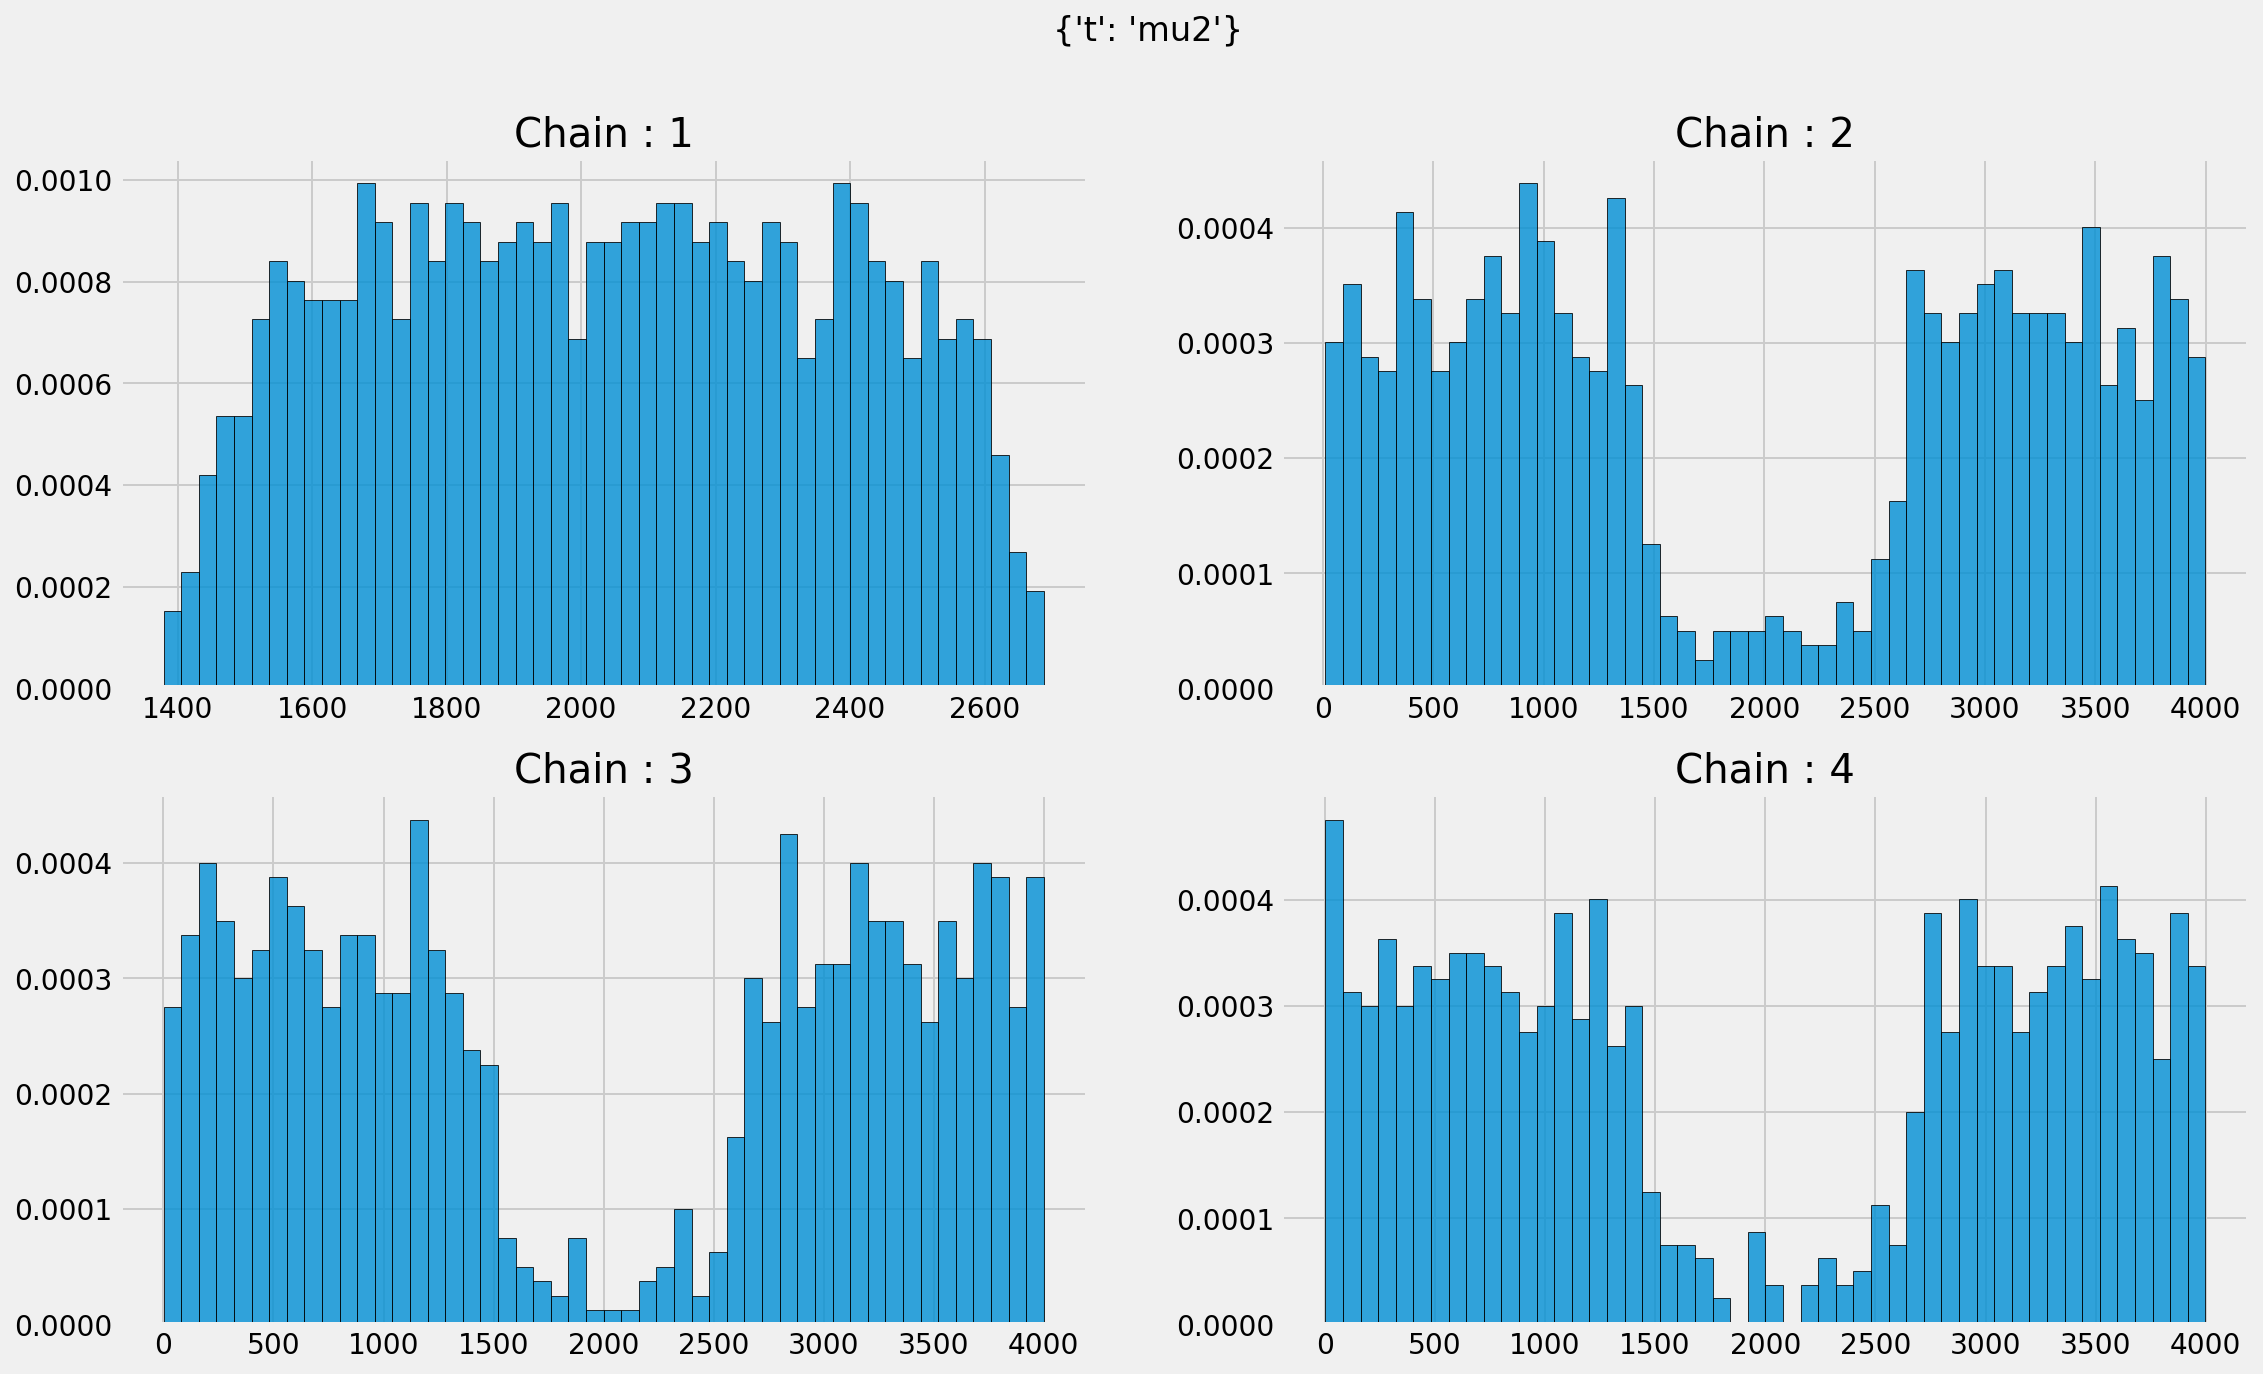

In [86]:
for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    plotutils.rankplot(trace_dvar[:,:,i], 4, 2, 2, t = string)